In [1]:
# Importing the required libraries
from IPython.display import display
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
import time
import easydict
import copy

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR, LinearLR

from time_transformer.transformer import Transformer
from time_transformer.utils_valid_loss_point import compute_val_point_score

# Training device check-up
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

writer = SummaryWriter()

# Defining DOE custom mape formula
def new_mape(y_true, y_pred, max_val):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / max_val)) * 100

# Defining DOE custom mape formula
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / max(y_true))) * 100

Using device cuda:0


#### FETCHING AND PROCESSING CALENDER FEATURES

In [2]:
# Specifying the path of file
path= r"C:\Users\sashah8\DOE_Graph_Attention_Transformer\DOE MODEL TRAINING\Cleaned data - Station mapped"
dataset = "L4"

# Listing just the required files
fileList = os.listdir(os.path.join(path, dataset))

# Previewing the required file names
print(fileList)

['CAPITL.csv', 'CENTRL.csv', 'DUNWOD.csv', 'GENESE.csv', 'HUD VL.csv', 'LONGIL.csv', 'MILLWD.csv', 'N.Y.C..csv']


In [3]:
# Just for previewing the column name
display(pd.read_csv(os.path.join(path, dataset, fileList[7])).head(2))

,utc,ept,mw,tmpf
0,2015-01-01 05:00:00,2015-01-01 00:00:00,5272.0,28.04
1,2015-01-01 06:00:00,2015-01-01 01:00:00,5092.6,28.04


In [4]:
# Just for previewing the column name
data = pd.read_csv(os.path.join(path, dataset, fileList[0]), parse_dates=['ept'], usecols=['ept', 'mw', 'tmpf'])
print("Sample dataframe: ")
display(data.head(2))

Sample dataframe: 


,ept,mw,tmpf
0,2015-01-01 00:00:00,1280.8,19.94
1,2015-01-01 01:00:00,1230.8,21.92


In [5]:
# Fetching the date column only
date_col = data.ept.copy()
date_col.name = "AA_ept"
date_col.head(2)

0   2015-01-01 00:00:00
1   2015-01-01 01:00:00
Name: AA_ept, dtype: datetime64[ns]

In [6]:
# Creating the calendar features
date = pd.DataFrame()
date['Month'] = date_col.dt.month
date['Day'] = date_col.dt.day
date['Hour'] = date_col.dt.hour
date['Weekday'] = date_col.dt.weekday

print("Sample calendar features: ")
display(date.head(2))

print("Available unique categories: ")
display(date.nunique())

print("Total number of observations: ", len(date))

Sample calendar features: 


,Month,Day,Hour,Weekday
0,1,1,0,3
1,1,1,1,3


Available unique categories: 


Month      12
Day        31
Hour       24
Weekday     7
dtype: int64

Total number of observations:  43824


In [7]:
# One-hot encoding the categorical calendar features
date_enc = OneHotEncoder(sparse_output=False)
categorical_data = date_enc.fit_transform(date)
display(categorical_data)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
category_count = [len(x_len) for x_len in date_enc.categories_]
category_count

[12, 31, 24, 7]

#### PROCESSING CONTINUOUS FEATURES FOR ALL AVAILABLE ZONES

PROCESSING LOAD DATA

In [9]:
# Fetching and concatenating the data
load_ds = pd.concat([pd.read_csv(os.path.join(path, dataset, fileName),
                                 usecols= ["mw"]) for fileName in fileList], axis= 1)
load_ds.columns = [i.removesuffix('.csv') for i in fileList]
load_ds = load_ds.add_suffix("_A_LOAD")

display(load_ds.tail(3))

,CAPITL_A_LOAD,CENTRL_A_LOAD,DUNWOD_A_LOAD,GENESE_A_LOAD,HUD VL_A_LOAD,LONGIL_A_LOAD,MILLWD_A_LOAD,N.Y.C._A_LOAD
43821,1339.0,1804.6,637.9,1094.5,1091.2,2324.1,347.3,5488.3
43822,1280.9,1734.2,608.4,1049.6,1041.3,2201.8,326.5,5276.0
43823,1225.9,1677.7,579.8,1023.4,994.3,2090.2,309.9,5063.4


In [10]:
lag_24_ahead = True

# Creating 1-day lag loads
if lag_24_ahead:
    lag_val = 1
else:
    lag_val = 2

load_lag_1 = load_ds.shift(24*lag_val).add_suffix("_LAG1")
display(load_lag_1.tail(3))

,CAPITL_A_LOAD_LAG1,CENTRL_A_LOAD_LAG1,DUNWOD_A_LOAD_LAG1,GENESE_A_LOAD_LAG1,HUD VL_A_LOAD_LAG1,LONGIL_A_LOAD_LAG1,MILLWD_A_LOAD_LAG1,N.Y.C._A_LOAD_LAG1
43821,1413.1,1853.3,683.9,1110.0,1167.4,2487.5,395.1,5793.5
43822,1310.5,1734.9,639.0,1038.7,1088.6,2306.0,358.1,5505.2
43823,1219.7,1657.8,593.0,987.1,1007.3,2109.5,322.1,5188.7


In [11]:
# Creating 7-day lag loads
load_lag_7 = load_ds.shift(24*7).add_suffix("_LAG7")
display(load_lag_7.tail(2))

,CAPITL_A_LOAD_LAG7,CENTRL_A_LOAD_LAG7,DUNWOD_A_LOAD_LAG7,GENESE_A_LOAD_LAG7,HUD VL_A_LOAD_LAG7,LONGIL_A_LOAD_LAG7,MILLWD_A_LOAD_LAG7,N.Y.C._A_LOAD_LAG7
43822,1304.1,1738.8,630.8,1046.8,1094.8,2292.6,341.5,5244.8
43823,1237.0,1662.0,602.3,1005.7,1043.8,2184.3,322.6,5038.8


In [12]:
# Drop index for equalizing data
drop_idx = load_lag_7.dropna(axis=0).index[0]
print("Drop data before: ", drop_idx)

Drop data before:  168


ADDING LAST LOAD VALUE FROM PREVIOUS DAY AS FEATURE

In [13]:
n = 24
last_elem = pd.DataFrame(np.column_stack([np.concatenate([np.repeat(load_ds[col].values[n-1::n], n), 
                                                          np.repeat(np.NaN, len(load_ds)%n)]) for col in load_ds.columns]))
last_elem.columns = [i.removesuffix('.csv') for i in fileList]
last_elem = last_elem.add_suffix("_LAST_ELEM")
last_elem = last_elem.shift(24)
last_elem

,CAPITL_LAST_ELEM,CENTRL_LAST_ELEM,DUNWOD_LAST_ELEM,GENESE_LAST_ELEM,HUD VL_LAST_ELEM,LONGIL_LAST_ELEM,MILLWD_LAST_ELEM,N.Y.C._LAST_ELEM
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
43819,1219.7,1657.8,593.0,987.1,1007.3,2109.5,322.1,5188.7
43820,1219.7,1657.8,593.0,987.1,1007.3,2109.5,322.1,5188.7
43821,1219.7,1657.8,593.0,987.1,1007.3,2109.5,322.1,5188.7
43822,1219.7,1657.8,593.0,987.1,1007.3,2109.5,322.1,5188.7


FINDING MIN AND MAX VALUES OF LOAD ON PREVIOUS DAY

In [14]:
# Creating block of indices repeating after every 24 rows
blocks = [load_lag_1[i:i+24] for i in range(0, len(load_lag_1), 24)]

# Finding max and min values on the previous day (T-1)
max_values_df = pd.DataFrame([block.max() for block in blocks])
max_values_df = max_values_df.iloc[np.repeat(np.arange(len(max_values_df)), 24)]
max_values_df = max_values_df.reset_index(drop=True)

max_values_df.columns = [i.removesuffix('_A_LOAD_LAG1') for i in max_values_df.columns]
max_values_df = max_values_df.add_suffix("_PREV_MAX")
print("Columns with max load from previous day: ")
display(max_values_df.tail(2))
print("\n")

min_values_df = pd.DataFrame([block.min() for block in blocks])
min_values_df = min_values_df.iloc[np.repeat(np.arange(len(min_values_df)), 24)]
min_values_df = min_values_df.reset_index(drop=True)

min_values_df.columns = [i.removesuffix('_A_LOAD_LAG1') for i in min_values_df.columns]
min_values_df = min_values_df.add_suffix("_PREV_MIN")
print("Columns with min load from previous day: ")
display(min_values_df.tail(2))
print("\n")

Columns with max load from previous day: 


,CAPITL_PREV_MAX,CENTRL_PREV_MAX,DUNWOD_PREV_MAX,GENESE_PREV_MAX,HUD VL_PREV_MAX,LONGIL_PREV_MAX,MILLWD_PREV_MAX,N.Y.C._PREV_MAX
43822,1625.9,2051.9,768.0,1256.9,1312.6,2790.3,436.4,6528.0
43823,1625.9,2051.9,768.0,1256.9,1312.6,2790.3,436.4,6528.0




Columns with min load from previous day: 


,CAPITL_PREV_MIN,CENTRL_PREV_MIN,DUNWOD_PREV_MIN,GENESE_PREV_MIN,HUD VL_PREV_MIN,LONGIL_PREV_MIN,MILLWD_PREV_MIN,N.Y.C._PREV_MIN
43822,1110.7,1535.0,496.3,882.1,880.8,1698.2,250.3,4356.8
43823,1110.7,1535.0,496.3,882.1,880.8,1698.2,250.3,4356.8


In [15]:
pd.DataFrame(load_lag_1.iloc[-24:].max()).T

,CAPITL_A_LOAD_LAG1,CENTRL_A_LOAD_LAG1,DUNWOD_A_LOAD_LAG1,GENESE_A_LOAD_LAG1,HUD VL_A_LOAD_LAG1,LONGIL_A_LOAD_LAG1,MILLWD_A_LOAD_LAG1,N.Y.C._A_LOAD_LAG1
0,1625.9,2051.9,768.0,1256.9,1312.6,2790.3,436.4,6528.0


PROCESSING TEMPERATURE DATA

In [16]:
# Fetching and concatenating the data
temp_ds = pd.concat([pd.read_csv(os.path.join(path, dataset, fileName),
                                 usecols= ["tmpf"]) for fileName in fileList], axis= 1)
temp_ds.columns = [i.removesuffix('.csv') for i in fileList]
temp_ds = temp_ds.add_suffix("_A_TEMP")

display(temp_ds.tail(3))

,CAPITL_A_TEMP,CENTRL_A_TEMP,DUNWOD_A_TEMP,GENESE_A_TEMP,HUD VL_A_TEMP,LONGIL_A_TEMP,MILLWD_A_TEMP,N.Y.C._A_TEMP
43821,36.0,32.0,39.9,33.1,37.4,42.1,39.9,43.0
43822,35.1,30.9,39.0,32.0,37.4,42.1,39.0,43.0
43823,35.1,30.9,39.0,33.1,35.6,42.1,39.0,42.1


### PREPARING X AND Y PART

In [17]:
# Concatenating the engineered features
X_continuous = pd.concat([date_col, load_lag_1, load_lag_7, temp_ds, last_elem, max_values_df, min_values_df], axis=1)
X_continuous = X_continuous.sort_index(axis=1)
X_continuous = X_continuous.iloc[drop_idx:].reset_index(drop=True)

# Fetching the train index from the processed dataframe
train_end_idx = X_continuous[X_continuous.AA_ept.dt.year.between(2015, 2018)].index[-1]
print("NUMBER OF COLUMNS: ", len(X_continuous.columns), "\n")
print("The train-test split index is: ", train_end_idx)
print("The last date of train dataset: ")
display(X_continuous.loc[:train_end_idx].tail(2))

print("The first date of test dataset: ")
display(X_continuous.loc[train_end_idx + 1:].head(2))
print('\n')

# Dropping the datetime column after fetching the train-test split index
X_continuous = X_continuous.drop(columns=['AA_ept'])
print("LENGTH OF DATASET: ", len(X_continuous))
display(X_continuous.tail(2))
print("\n")

# First few values of the continuous values dataframe
print("First few values of continuous values dataframe: ")
display(X_continuous.head(2))

NUMBER OF COLUMNS:  49 

The train-test split index is:  34895
The last date of train dataset: 


,AA_ept,CAPITL_A_LOAD_LAG1,CAPITL_A_LOAD_LAG7,CAPITL_A_TEMP,CAPITL_LAST_ELEM,CAPITL_PREV_MAX,CAPITL_PREV_MIN,CENTRL_A_LOAD_LAG1,CENTRL_A_LOAD_LAG7,CENTRL_A_TEMP,...,MILLWD_A_TEMP,MILLWD_LAST_ELEM,MILLWD_PREV_MAX,MILLWD_PREV_MIN,N.Y.C._A_LOAD_LAG1,N.Y.C._A_LOAD_LAG7,N.Y.C._A_TEMP,N.Y.C._LAST_ELEM,N.Y.C._PREV_MAX,N.Y.C._PREV_MIN
34894,2018-12-31 22:00:00,1326.5,1283.0,39.0,1256.2,1580.7,1143.9,1847.5,1757.1,39.9,...,42.1,286.1,380.3,252.5,5307.2,5280.6,45.0,5039.4,5797.9,4290.1
34895,2018-12-31 23:00:00,1256.2,1212.0,39.9,1256.2,1580.7,1143.9,1763.1,1678.4,41.0,...,43.0,286.1,380.3,252.5,5039.4,5062.8,46.0,5039.4,5797.9,4290.1


The first date of test dataset: 


,AA_ept,CAPITL_A_LOAD_LAG1,CAPITL_A_LOAD_LAG7,CAPITL_A_TEMP,CAPITL_LAST_ELEM,CAPITL_PREV_MAX,CAPITL_PREV_MIN,CENTRL_A_LOAD_LAG1,CENTRL_A_LOAD_LAG7,CENTRL_A_TEMP,...,MILLWD_A_TEMP,MILLWD_LAST_ELEM,MILLWD_PREV_MAX,MILLWD_PREV_MIN,N.Y.C._A_LOAD_LAG1,N.Y.C._A_LOAD_LAG7,N.Y.C._A_TEMP,N.Y.C._LAST_ELEM,N.Y.C._PREV_MAX,N.Y.C._PREV_MIN
34896,2019-01-01 00:00:00,1188.4,1144.5,39.9,1188.9,1544.9,1138.9,1697.8,1603.8,42.1,...,43.0,293.4,382.2,251.3,4787.4,4842.1,46.9,5103.1,6332.1,4409.1
34897,2019-01-01 01:00:00,1152.4,1102.4,41.0,1188.9,1544.9,1138.9,1642.2,1552.2,44.1,...,43.0,293.4,382.2,251.3,4590.9,4665.1,46.9,5103.1,6332.1,4409.1




LENGTH OF DATASET:  43656


,CAPITL_A_LOAD_LAG1,CAPITL_A_LOAD_LAG7,CAPITL_A_TEMP,CAPITL_LAST_ELEM,CAPITL_PREV_MAX,CAPITL_PREV_MIN,CENTRL_A_LOAD_LAG1,CENTRL_A_LOAD_LAG7,CENTRL_A_TEMP,CENTRL_LAST_ELEM,...,MILLWD_A_TEMP,MILLWD_LAST_ELEM,MILLWD_PREV_MAX,MILLWD_PREV_MIN,N.Y.C._A_LOAD_LAG1,N.Y.C._A_LOAD_LAG7,N.Y.C._A_TEMP,N.Y.C._LAST_ELEM,N.Y.C._PREV_MAX,N.Y.C._PREV_MIN
43654,1310.5,1304.1,35.1,1219.7,1625.9,1110.7,1734.9,1738.8,30.9,1657.8,...,39.0,322.1,436.4,250.3,5505.2,5244.8,43.0,5188.7,6528.0,4356.8
43655,1219.7,1237.0,35.1,1219.7,1625.9,1110.7,1657.8,1662.0,30.9,1657.8,...,39.0,322.1,436.4,250.3,5188.7,5038.8,42.1,5188.7,6528.0,4356.8




First few values of continuous values dataframe: 


,CAPITL_A_LOAD_LAG1,CAPITL_A_LOAD_LAG7,CAPITL_A_TEMP,CAPITL_LAST_ELEM,CAPITL_PREV_MAX,CAPITL_PREV_MIN,CENTRL_A_LOAD_LAG1,CENTRL_A_LOAD_LAG7,CENTRL_A_TEMP,CENTRL_LAST_ELEM,...,MILLWD_A_TEMP,MILLWD_LAST_ELEM,MILLWD_PREV_MAX,MILLWD_PREV_MIN,N.Y.C._A_LOAD_LAG1,N.Y.C._A_LOAD_LAG7,N.Y.C._A_TEMP,N.Y.C._LAST_ELEM,N.Y.C._PREV_MAX,N.Y.C._PREV_MIN
0,1359.7,1280.8,-2.92,1552.1,1924.6,1308.7,1935.3,1813.7,2.12,2181.8,...,6.98,414.5,536.7,327.2,5343.2,5272.0,8.96,6104.6,7523.0,4895.0
1,1324.6,1230.8,-4.00,1552.1,1924.6,1308.7,1890.7,1737.4,1.04,2181.8,...,6.08,414.5,536.7,327.2,5108.7,5092.6,8.96,6104.6,7523.0,4895.0


In [18]:
X_categorical = pd.DataFrame(categorical_data)
X_categorical = X_categorical.iloc[drop_idx:].reset_index(drop=True)
print("LENGTH OF DATASET: ", len(X_categorical))
print("NUMBER OF COLUMNS: ", len(X_categorical.columns))
display(X_categorical.tail(3))

LENGTH OF DATASET:  43656
NUMBER OF COLUMNS:  74


,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
43653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
43654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
43655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [19]:
Y = load_ds.copy()
Y = Y.sort_index(axis=1)
Y = Y.iloc[drop_idx:].reset_index(drop=True)
print("LENGTH OF DATASET: ", len(Y))
display(Y.tail(3))

LENGTH OF DATASET:  43656


,CAPITL_A_LOAD,CENTRL_A_LOAD,DUNWOD_A_LOAD,GENESE_A_LOAD,HUD VL_A_LOAD,LONGIL_A_LOAD,MILLWD_A_LOAD,N.Y.C._A_LOAD
43653,1339.0,1804.6,637.9,1094.5,1091.2,2324.1,347.3,5488.3
43654,1280.9,1734.2,608.4,1049.6,1041.3,2201.8,326.5,5276.0
43655,1225.9,1677.7,579.8,1023.4,994.3,2090.2,309.9,5063.4


In [20]:
### SPLITTING THE DATA INTO TRAINING AND TESTING
print("Train samples: ", len(X_continuous.loc[:train_end_idx]))
print("Test samples: ", len(X_continuous.loc[train_end_idx + 1:]))

Train samples:  34896
Test samples:  8760


In [21]:
# Splitting the continuous data into training and test split
X_continuous_train,  X_continuous_test = X_continuous.loc[:train_end_idx], X_continuous.loc[train_end_idx+1:]
print("Train split of continuous data: ")
display(X_continuous_train.tail(2))

# Splitting the categorical data into training and test split
X_categorical_train, X_categorical_test = X_categorical.loc[:train_end_idx], X_categorical.loc[train_end_idx+1:]
print("Train split of categorical data: ")
display(X_categorical_train.tail(2))

# Splitting the target into training and test split
Y_train, Y_test = Y.loc[:train_end_idx],  Y.loc[train_end_idx+1:]
print("Train split of target data Y: ")
display(Y_train.tail(2))

Train split of continuous data: 


,CAPITL_A_LOAD_LAG1,CAPITL_A_LOAD_LAG7,CAPITL_A_TEMP,CAPITL_LAST_ELEM,CAPITL_PREV_MAX,CAPITL_PREV_MIN,CENTRL_A_LOAD_LAG1,CENTRL_A_LOAD_LAG7,CENTRL_A_TEMP,CENTRL_LAST_ELEM,...,MILLWD_A_TEMP,MILLWD_LAST_ELEM,MILLWD_PREV_MAX,MILLWD_PREV_MIN,N.Y.C._A_LOAD_LAG1,N.Y.C._A_LOAD_LAG7,N.Y.C._A_TEMP,N.Y.C._LAST_ELEM,N.Y.C._PREV_MAX,N.Y.C._PREV_MIN
34894,1326.5,1283.0,39.0,1256.2,1580.7,1143.9,1847.5,1757.1,39.9,1763.1,...,42.1,286.1,380.3,252.5,5307.2,5280.6,45.0,5039.4,5797.9,4290.1
34895,1256.2,1212.0,39.9,1256.2,1580.7,1143.9,1763.1,1678.4,41.0,1763.1,...,43.0,286.1,380.3,252.5,5039.4,5062.8,46.0,5039.4,5797.9,4290.1


Train split of categorical data: 


,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
34894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
34895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Train split of target data Y: 


,CAPITL_A_LOAD,CENTRL_A_LOAD,DUNWOD_A_LOAD,GENESE_A_LOAD,HUD VL_A_LOAD,LONGIL_A_LOAD,MILLWD_A_LOAD,N.Y.C._A_LOAD
34894,1256.9,1742.2,651.7,1003.7,1049.9,2236.5,313.3,5330.7
34895,1188.9,1664.1,617.5,941.2,998.2,2108.9,293.4,5103.1


In [22]:
print("Shape for continuous variable: ")
print(X_continuous_train.shape, X_continuous_test.shape, "\n")
print("Shape for categorical variable: ")
print(X_categorical_train.shape, X_categorical_test.shape, "\n")
print("Shape for target variable: ")
print(Y_train.shape, Y_test.shape, "\n")
print("Does it cover entire training set: ", (X_continuous_train.shape[0] +
                                              X_continuous_test.shape[0]) == len(X_continuous))

Shape for continuous variable: 
(34896, 48) (8760, 48) 

Shape for categorical variable: 
(34896, 74) (8760, 74) 

Shape for target variable: 
(34896, 8) (8760, 8) 

Does it cover entire training set:  True


### SCALING THE DATA

In [23]:
# Scaling values using min-max scaler
mm_scaler_X = MinMaxScaler()
mm_scaler_Y = MinMaxScaler()

In [24]:
# Scaling continuous X train part
X_scaled_continuous_train = mm_scaler_X.fit_transform(X_continuous_train)

# Using the fit_scaler to scale the X test part
X_scaled_continuous_test = mm_scaler_X.transform(X_continuous_test)

print("Scaled continuous X train: ")
print("Shape: ", X_scaled_continuous_train.shape)
display(X_scaled_continuous_train)

Scaled continuous X train: 
Shape:  (34896, 48)


array([[0.3274163 , 0.27757423, 0.09163636, ..., 0.4214876 , 0.40653916,
        0.2845064 ],
       [0.30524321, 0.24598863, 0.08181818, ..., 0.4214876 , 0.40653916,
        0.2845064 ],
       [0.29576753, 0.22558433, 0.072     , ..., 0.4214876 , 0.40653916,
        0.2845064 ],
       ...,
       [0.36077069, 0.31692988, 0.47272727, ..., 0.17897229, 0.1178823 ,
        0.13091611],
       [0.30644346, 0.27896399, 0.47272727, ..., 0.17897229, 0.1178823 ,
        0.13091611],
       [0.26203411, 0.23411244, 0.48090909, ..., 0.17897229, 0.1178823 ,
        0.13091611]])

In [25]:
# Scaling target Y train part
Y_scaled_train = mm_scaler_Y.fit_transform(Y_train)

# Using the fit_scaler to scale the Y test part
Y_scaled_test = mm_scaler_Y.transform(Y_test)

print("Scaled continuous Y train: ")
print("Shape: ", Y_scaled_train.shape)
display(Y_scaled_train)

Scaled continuous Y train: 
Shape:  (34896, 8)


array([[0.43493367, 0.4948815 , 0.3230828 , ..., 0.25441229, 0.52029117,
        0.26610648],
       [0.44036639, 0.46678536, 0.29662878, ..., 0.22994761, 0.50263876,
        0.23122053],
       [0.40246368, 0.45504618, 0.28153949, ..., 0.21583338, 0.49972702,
        0.21196129],
       ...,
       [0.30322173, 0.33175698, 0.31964473, ..., 0.22951528, 0.41546861,
        0.24594254],
       [0.26247631, 0.28847224, 0.28650559, ..., 0.19698896, 0.38307552,
        0.21331835],
       [0.2195199 , 0.24502059, 0.25384395, ..., 0.16453893, 0.34686078,
        0.18211975]])

In [26]:
# Converting a multivariate dataset into slices of samples
def split_data(calendar_data, x_data, y_data, n_steps, n_overlap):
    calendar, x, y = list(), list(), list()
    for i in range(0, len(x_data), n_steps-n_overlap):

        # Finding the split index
        end_idx = i + n_steps

        # Break the loop at end of dataset
        if end_idx > len(x_data):
            break

        # Appending the custom created samples with desired time-steps and features
        sample_calendar, sample_x, sample_y = calendar_data[i:end_idx, :], \
                                              x_data[i:end_idx, :], \
                                              y_data[i:end_idx, :]
        calendar.append(sample_calendar)
        x.append(sample_x)
        y.append(sample_y)

    return np.array(calendar), np.array(x), np.array(y)

In [27]:
num_steps = 24
train_num_overlap = 23
test_num_overlap = 0

processed_data_train = split_data(calendar_data=X_categorical_train.to_numpy(),
                            x_data=X_scaled_continuous_train,
                            y_data=Y_scaled_train,
                            n_steps=num_steps, n_overlap=train_num_overlap)

processed_data_test = split_data(calendar_data=X_categorical_test.to_numpy(),
                            x_data=X_scaled_continuous_test,
                            y_data=Y_scaled_test,
                            n_steps=num_steps, n_overlap=test_num_overlap)

print("Shape of the created samples for training: ", processed_data_train[2].shape)
print("Shape of the created samples for testing: ", processed_data_test[2].shape)

Shape of the created samples for training:  (34873, 24, 8)
Shape of the created samples for testing:  (365, 24, 8)


In [28]:
## Sample check for sanity
print("First sample: \n")
display(processed_data_train[1][0])

First sample: 



array([[0.3274163 , 0.27757423, 0.09163636, ..., 0.4214876 , 0.40653916,
        0.2845064 ],
       [0.30524321, 0.24598863, 0.08181818, ..., 0.4214876 , 0.40653916,
        0.2845064 ],
       [0.29576753, 0.22558433, 0.072     , ..., 0.4214876 , 0.40653916,
        0.2845064 ],
       ...,
       [0.59368288, 0.36917246, 0.27327273, ..., 0.4214876 , 0.40653916,
        0.2845064 ],
       [0.52419457, 0.3087808 , 0.27327273, ..., 0.4214876 , 0.40653916,
        0.2845064 ],
       [0.44895768, 0.25173721, 0.26345455, ..., 0.4214876 , 0.40653916,
        0.2845064 ]])

In [29]:
print("Second sample: \n")
display(processed_data_train[1][1])

Second sample: 



array([[0.30524321, 0.24598863, 0.08181818, ..., 0.4214876 , 0.40653916,
        0.2845064 ],
       [0.29576753, 0.22558433, 0.072     , ..., 0.4214876 , 0.40653916,
        0.2845064 ],
       [0.29519899, 0.2195199 , 0.06381818, ..., 0.4214876 , 0.40653916,
        0.2845064 ],
       ...,
       [0.52419457, 0.3087808 , 0.27327273, ..., 0.4214876 , 0.40653916,
        0.2845064 ],
       [0.44895768, 0.25173721, 0.26345455, ..., 0.4214876 , 0.40653916,
        0.2845064 ],
       [0.43493367, 0.21351864, 0.26345455, ..., 0.40851035, 0.42482807,
        0.37761528]])

In [30]:
# Dividing the sampled data - training
categorical_samples_training = torch.Tensor(processed_data_train[0])
continuous_samples_training = torch.Tensor(processed_data_train[1])
target_samples_training = torch.Tensor(processed_data_train[2])

# Dividing the sampled data - testing
categorical_samples_testing = torch.Tensor(processed_data_test[0])
continuous_samples_testing = torch.Tensor(processed_data_test[1])
target_samples_testing = torch.Tensor(processed_data_test[2])

In [31]:
print("Shape of categorical samples - training: ", categorical_samples_training.shape)
print("Shape of continuous samples - training: ", continuous_samples_training.shape)
print("Shape of target samples - training: ", target_samples_training.shape)
print("\n")
print("Shape of categorical samples - testing: ", categorical_samples_testing.shape)
print("Shape of continuous samples - testing: ", continuous_samples_testing.shape)
print("Shape of target samples - testing: ", target_samples_testing.shape)

Shape of categorical samples - training:  torch.Size([34873, 24, 74])
Shape of continuous samples - training:  torch.Size([34873, 24, 48])
Shape of target samples - training:  torch.Size([34873, 24, 8])


Shape of categorical samples - testing:  torch.Size([365, 24, 74])
Shape of continuous samples - testing:  torch.Size([365, 24, 48])
Shape of target samples - testing:  torch.Size([365, 24, 8])


### CREATING DATALOADER

In [32]:
BATCH_SIZE = 512

In [33]:
class TimeSeriesLoader(Dataset):
    def __init__(self, categorical, continuous, target):
        self.categorical, self.continuous, self.target = categorical, continuous, target

    def __len__(self):
        return len(self.categorical)

    def __getitem__(self, idx):
        return self.categorical[idx], self.continuous[idx], self.target[idx]

In [34]:
train_dataset = TimeSeriesLoader(categorical_samples_training,
                                 continuous_samples_training,
                                 target_samples_training)

test_dataset = TimeSeriesLoader(categorical_samples_testing,
                                continuous_samples_testing,
                                target_samples_testing)

In [35]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [36]:
print("Number of batches in train dataloader: ", len(train_dataloader))
print("Number of batches in test dataloader: ", len(test_dataloader))

Number of batches in train dataloader:  69
Number of batches in test dataloader:  1


In [37]:
categorical_var_shape = train_dataloader.dataset.categorical.shape
continuous_var_shape = train_dataloader.dataset.continuous.shape
target_var_shape = train_dataloader.dataset.target.shape

print("Shape of categorical variables: ", categorical_var_shape)
print("Shape of continuous variables: ", continuous_var_shape)
print("Shape of target variables: ", target_var_shape)

Shape of categorical variables:  torch.Size([34873, 24, 74])
Shape of continuous variables:  torch.Size([34873, 24, 48])
Shape of target variables:  torch.Size([34873, 24, 8])


In [38]:
# Specifying number of zones and features per zone
num_zones = target_var_shape[2]
num_zone_features = int(continuous_var_shape[2] / target_var_shape[2])
print("Number of zones: ", num_zones)
print("Number of features per zone: ", num_zone_features)

Number of zones:  8
Number of features per zone:  6


### DEFINING LOSS FUNCTION

In [39]:
loss_function = nn.MSELoss()

### DEFINING MODEL ARCHITECTURE

In [40]:
config_args = easydict.EasyDict(
        {
            "device": torch.device("cuda")
            if torch.cuda.is_available()
            else torch.device("cpu"),
            "learning_rate": 1e-4,
            "weight_decay": 1e-3,
            "max_iter": 1000,
            "epochs": 200,
            "update_freq": 10
        }
    )

model_args = easydict.EasyDict(
        {
            "d_input": num_zone_features + 3 + X_categorical_train.shape[1],     # Model input -> Continuous + Categorical
            "d_output": 1,                                                       # Model output -> Point predictions
            "d_model": 256,                                                       # Model latent dimension
            "q": 3,                                                              # Query and Key dimensions
            "v": 3,                                                              # Value dimensions
            "h": 3,                                                              # Number of heads
            "N": 1,                                                              # Number of stacked of encoder and decoder
            "attention_size": 24*7,                                              # Attention window
            "dropout": 0.5,                                                      # Dropout rate
            "pe": "regular",                                                     # Positional encoding used
            "chunk_mode": None,                                                  # Default -> MultiHeadAttention
        }
    )

# Making directories to store values
if not os.path.exists("logs"):
    os.mkdir("logs")
if not os.path.exists("models"):
    os.mkdir("models")

### INSTANTIATING MODELS -> VAE AND LSTM

In [41]:
# Address for saved VAE models
vae_dirname = os.path.join(os.path.dirname(os.getcwd()), "VAE_LSTM", "vae_models")

# Loading the vae models
vae_model_1 = torch.load(os.path.join(vae_dirname, "L4_best_zone_1.pth"))
vae_model_2 = torch.load(os.path.join(vae_dirname, "L4_best_zone_2.pth"))
vae_model_3 = torch.load(os.path.join(vae_dirname, "L4_best_zone_3.pth"))
vae_model_4 = torch.load(os.path.join(vae_dirname, "L4_best_zone_4.pth"))
vae_model_5 = torch.load(os.path.join(vae_dirname, "L4_best_zone_5.pth"))
vae_model_6 = torch.load(os.path.join(vae_dirname, "L4_best_zone_6.pth"))
vae_model_7 = torch.load(os.path.join(vae_dirname, "L4_best_zone_7.pth"))
vae_model_8 = torch.load(os.path.join(vae_dirname, "L4_best_zone_8.pth"))

vae_models = nn.ModuleList([vae_model_1, vae_model_2, vae_model_3, vae_model_4,
                            vae_model_5, vae_model_6, vae_model_7, vae_model_8])
print("Number of vae models: ", len(vae_models))

Number of vae models:  8


In [42]:
# Instantiating transformer corresponding to each zone
transformer_model = Transformer(model_args.d_input, model_args.d_model, model_args.d_output,
                                model_args.q, model_args.v, model_args.h, model_args.N,
                                attention_size=model_args.attention_size, dropout=model_args.dropout,
                                chunk_mode=model_args.chunk_mode, pe=model_args.pe).to(device)

transformer_models = nn.ModuleList([transformer_model for _ in range(num_zones)])
print("Number of transformer models: ", len(transformer_models))

Number of transformer models:  8


In [43]:
class VAE_TRANSFORMER(nn.Module):
    def __init__(self, zonal_vae, zonal_transformer):
        super(VAE_TRANSFORMER, self).__init__()
        self.zonal_vae = zonal_vae
        self.zonal_transformer = zonal_transformer

    def forward(self, categorical, zonal_continuous):
        zonal_continuous_reconstr = zonal_continuous[:, :, :3]
        out_var = self.zonal_vae(zonal_continuous_reconstr)
        in_transformer = torch.cat((categorical, zonal_continuous, out_var[1]), axis=-1)
        out_transformer = self.zonal_transformer(in_transformer)
        return out_var, out_transformer

In [44]:
def frozen_param_model(net):
    for name, param in net.named_parameters():
        if param.requires_grad and 'zonal_vae' in name:
            param.requires_grad = False

    non_frozen_param = [p for p in net.parameters() if p.requires_grad]
    return non_frozen_param

In [45]:
def save_checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

def load_from_checkpoint(model, filename):
    model.load_state_dict(torch.load(filename))
    return model

def init_weights(model):
    if isinstance(model, nn.Linear):
        torch.nn.init.kaiming_uniform_(model.weight, nonlinearity='relu')
        model.bias.data.fill_(0.01)

### SPECIFYING EARLY STOPPING FUNCTION

In [46]:
class EarlyStopping:
    def __init__(self, patience=8, verbose=False, 
                 path="best_model.pth", trace_func=print,
                 model_name="model_x"):

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.path = path
        self.trace_func = trace_func
        self.model_name = model_name

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            
        elif score < self.best_score:
            self.counter += 1
            self.trace_func(f'[{self.model_name}] EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'[{self.model_name}] Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [47]:
early_stop_patience = 5

model_path_1 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_1.pth")
model_path_2 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_2.pth")
model_path_3 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_3.pth")
model_path_4 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_4.pth")
model_path_5 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_5.pth")
model_path_6 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_6.pth")
model_path_7 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_7.pth")
model_path_8 = os.path.join(os.getcwd(), "transformer_checkpoint_point_forecast", "vae_transformer_best_8.pth")

early_stopping_1 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_1, model_name="model_1")
early_stopping_2 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_2, model_name="model_2")
early_stopping_3 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_3, model_name="model_3")
early_stopping_4 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_4, model_name="model_4")
early_stopping_5 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_5, model_name="model_5")
early_stopping_6 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_6, model_name="model_6")
early_stopping_7 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_7, model_name="model_7")
early_stopping_8 = EarlyStopping(patience=early_stop_patience, verbose=True, path=model_path_8, model_name="model_8")

### DEFINING ZONAL MODEL

In [48]:
model_1 = VAE_TRANSFORMER(vae_models[0], transformer_models[0]).apply(init_weights)
model_2 = VAE_TRANSFORMER(vae_models[1], transformer_models[1]).apply(init_weights)
model_3 = VAE_TRANSFORMER(vae_models[2], transformer_models[2]).apply(init_weights)
model_4 = VAE_TRANSFORMER(vae_models[3], transformer_models[3]).apply(init_weights)
model_5 = VAE_TRANSFORMER(vae_models[4], transformer_models[4]).apply(init_weights)
model_6 = VAE_TRANSFORMER(vae_models[5], transformer_models[5]).apply(init_weights)
model_7 = VAE_TRANSFORMER(vae_models[6], transformer_models[6]).apply(init_weights)
model_8 = VAE_TRANSFORMER(vae_models[7], transformer_models[7]).apply(init_weights)

In [49]:
# Defining optimizer with frozen vae parameters -> Just training the Transformer
optimizer_1 = optim.Adam(frozen_param_model(model_1), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)
optimizer_2 = optim.Adam(frozen_param_model(model_2), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)
optimizer_3 = optim.Adam(frozen_param_model(model_3), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)
optimizer_4 = optim.Adam(frozen_param_model(model_4), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)
optimizer_5 = optim.Adam(frozen_param_model(model_5), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)
optimizer_6 = optim.Adam(frozen_param_model(model_6), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)
optimizer_7 = optim.Adam(frozen_param_model(model_7), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)
optimizer_8 = optim.Adam(frozen_param_model(model_8), lr=config_args.learning_rate, weight_decay=config_args.weight_decay)

### PERFORMING MODEL TRAINING


[Epoch     1 of 200] loss_1: 0.145453 val_loss_1: 0.124590 loss_2: 0.146048 val_loss_2: 0.128502 loss_3: 0.132584 val_loss_3: 0.120062 loss_4: 0.121893 val_loss_4: 0.106033 loss_5: 0.106847 val_loss_5: 0.090027 loss_6: 0.090186 val_loss_6: 0.076114 loss_7: 0.181050 val_loss_7: 0.177733 loss_8: 0.129543 val_loss_8: 0.115848
[model_1] Validation loss decreased (inf --> 0.124590).  Saving model ...
[model_2] Validation loss decreased (inf --> 0.128502).  Saving model ...
[model_3] Validation loss decreased (inf --> 0.120062).  Saving model ...
[model_4] Validation loss decreased (inf --> 0.106033).  Saving model ...
[model_5] Validation loss decreased (inf --> 0.090027).  Saving model ...
[model_6] Validation loss decreased (inf --> 0.076114).  Saving model ...
[model_7] Validation loss decreased (inf --> 0.177733).  Saving model ...
[model_8] Validation loss decreased (inf --> 0.115848).  Saving model ...

[Epoch     2 of 200] loss_1: 0.146284 val_loss_1: 0.124589 loss_2: 0.146812 val_l

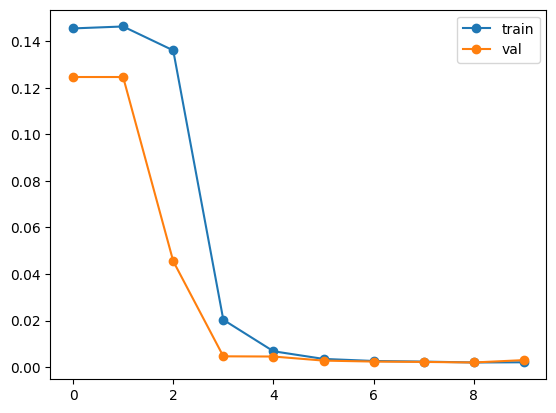

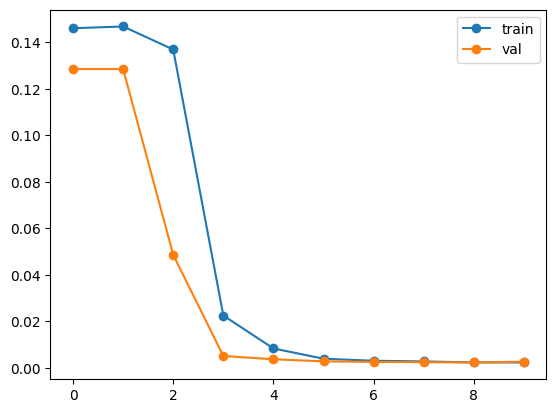

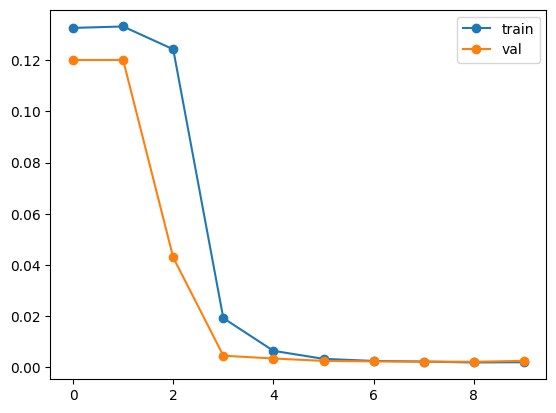

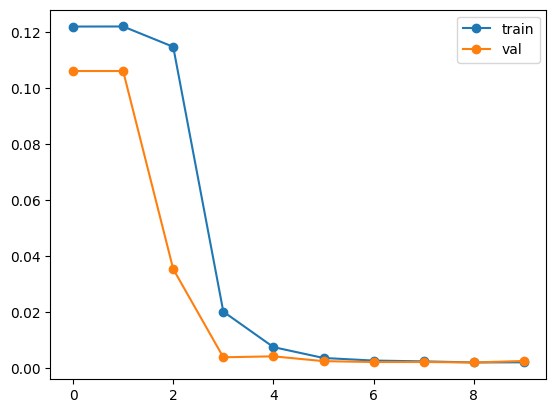

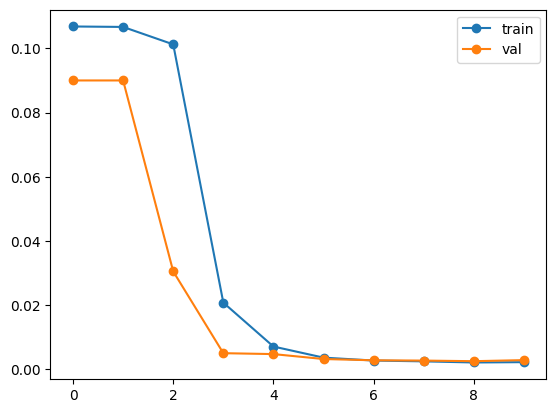

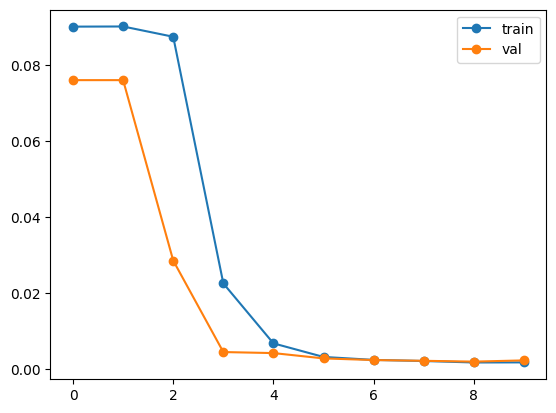

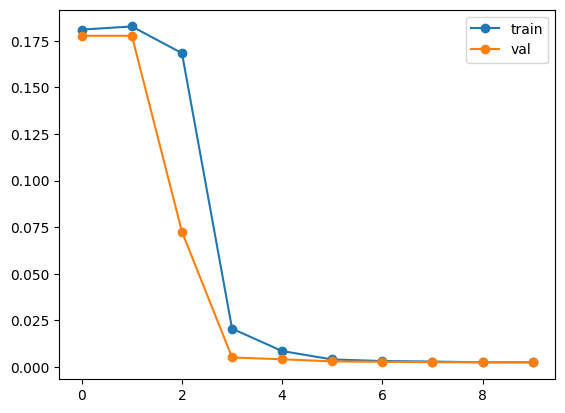

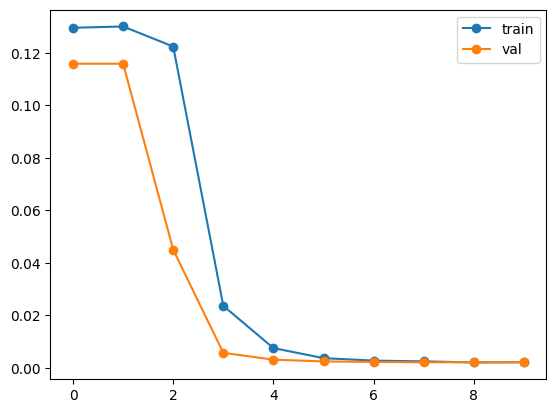


[Epoch    11 of 200] loss_1: 0.002033 val_loss_1: 0.002144 loss_2: 0.002187 val_loss_2: 0.001999 loss_3: 0.001944 val_loss_3: 0.001943 loss_4: 0.002035 val_loss_4: 0.001921 loss_5: 0.002174 val_loss_5: 0.002307 loss_6: 0.001781 val_loss_6: 0.001936 loss_7: 0.002393 val_loss_7: 0.002059 loss_8: 0.001951 val_loss_8: 0.001684
[model_1] EarlyStopping counter: 2 out of 5
[model_2] Validation loss decreased (0.002248 --> 0.001999).  Saving model ...
[model_3] Validation loss decreased (0.002219 --> 0.001943).  Saving model ...
[model_4] Validation loss decreased (0.002068 --> 0.001921).  Saving model ...
[model_5] Validation loss decreased (0.002545 --> 0.002307).  Saving model ...
[model_6] Validation loss decreased (0.002068 --> 0.001936).  Saving model ...
[model_7] Validation loss decreased (0.002369 --> 0.002059).  Saving model ...
[model_8] Validation loss decreased (0.002054 --> 0.001684).  Saving model ...

[Epoch    12 of 200] loss_1: 0.001696 val_loss_1: 0.002341 loss_2: 0.001841 

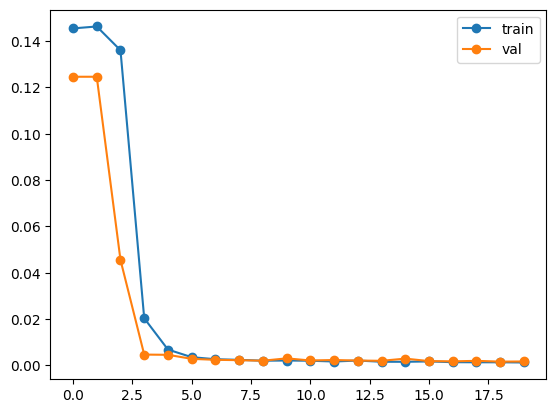

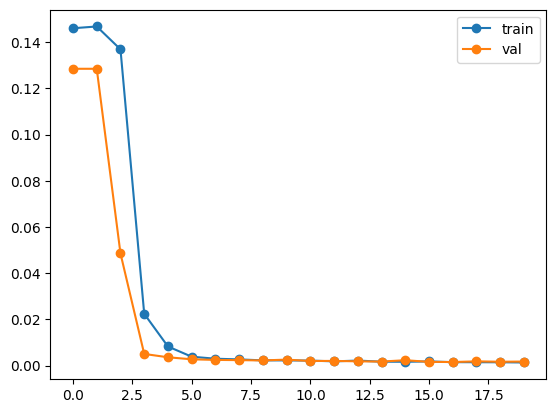

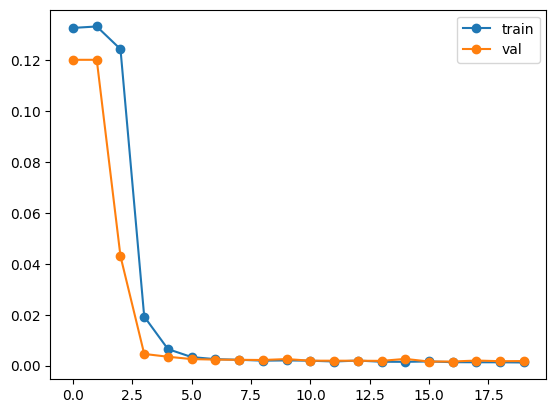

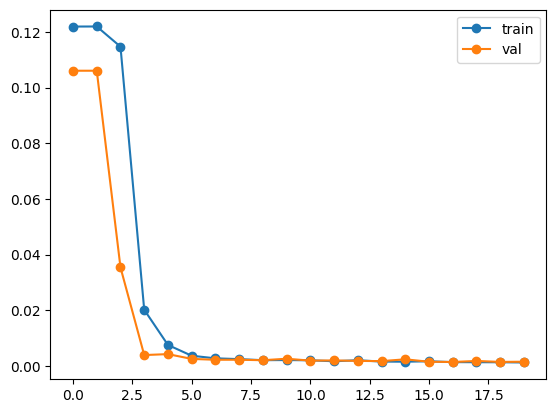

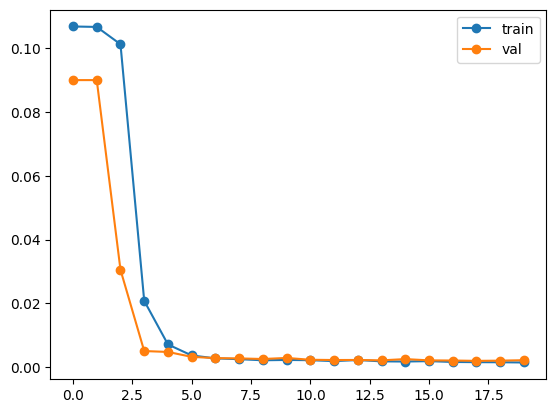

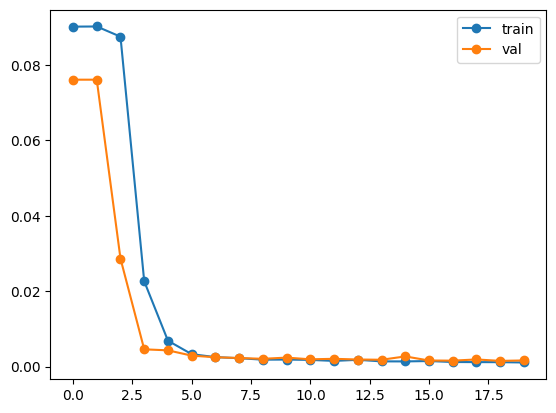

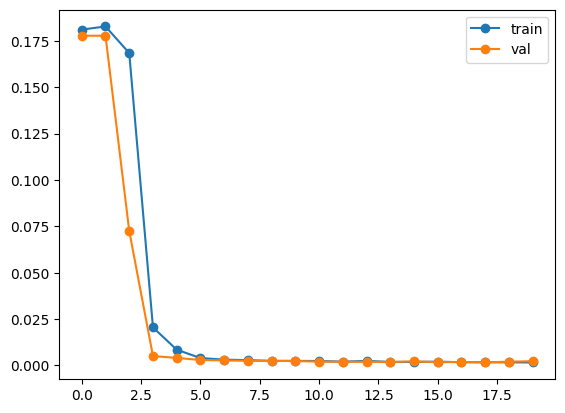

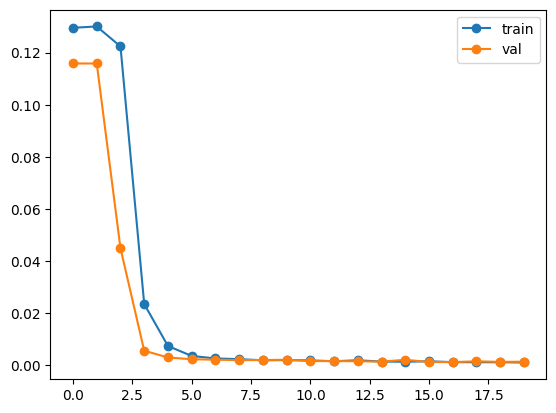


[Epoch    21 of 200] loss_1: 0.001294 val_loss_1: 0.001929 loss_2: 0.001406 val_loss_2: 0.001618 loss_3: 0.001281 val_loss_3: 0.001756 loss_4: 0.001282 val_loss_4: 0.001542 loss_5: 0.001493 val_loss_5: 0.001857 loss_6: 0.001118 val_loss_6: 0.001649 loss_7: 0.001656 val_loss_7: 0.001607 loss_8: 0.001180 val_loss_8: 0.001352
[model_1] EarlyStopping counter: 2 out of 5
[model_2] EarlyStopping counter: 4 out of 5
[model_3] EarlyStopping counter: 5 out of 5
[model_4] EarlyStopping counter: 4 out of 5
[model_5] Validation loss decreased (0.001960 --> 0.001857).  Saving model ...
[model_6] EarlyStopping counter: 2 out of 5
[model_7] Validation loss decreased (0.001705 --> 0.001607).  Saving model ...
[model_8] EarlyStopping counter: 4 out of 5
Early stopping - model_3

[Epoch    22 of 200] loss_1: 0.001227 val_loss_1: 0.002410 loss_2: 0.001307 val_loss_2: 0.001913 loss_3: 0.001209 val_loss_3: 0.001952 loss_4: 0.001210 val_loss_4: 0.001782 loss_5: 0.001419 val_loss_5: 0.002384 loss_6: 0.00107

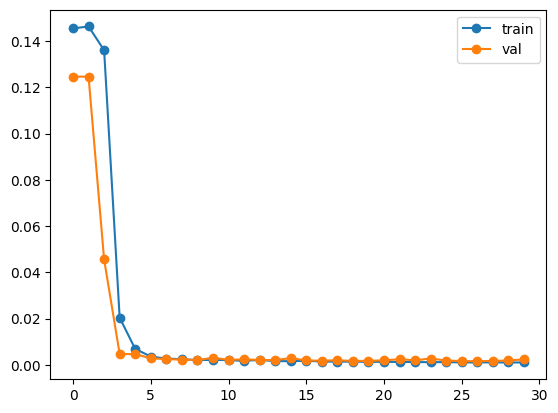

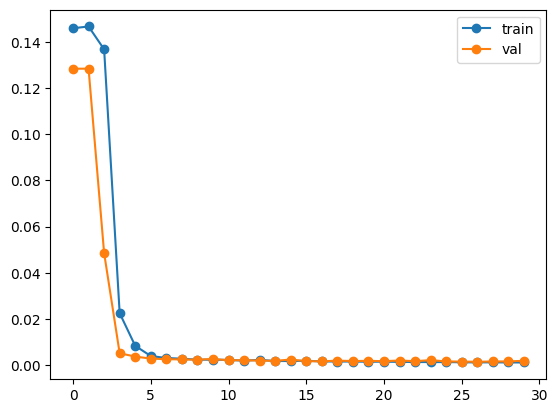

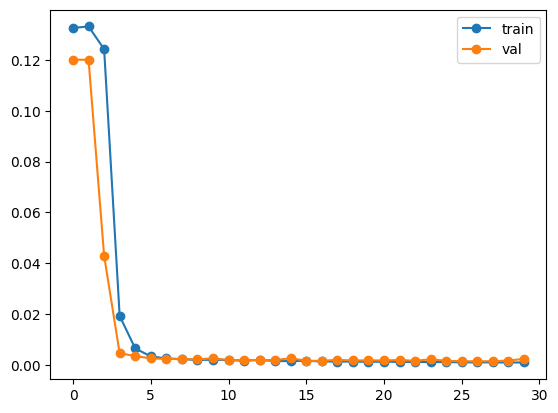

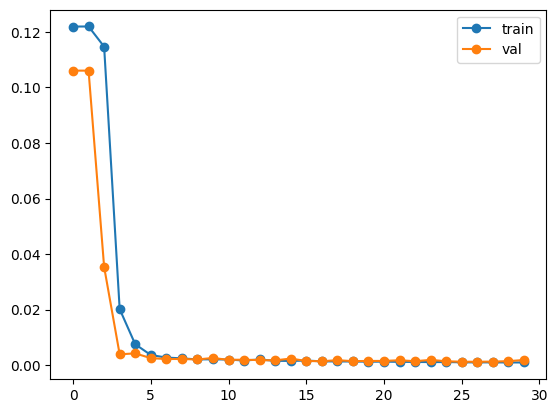

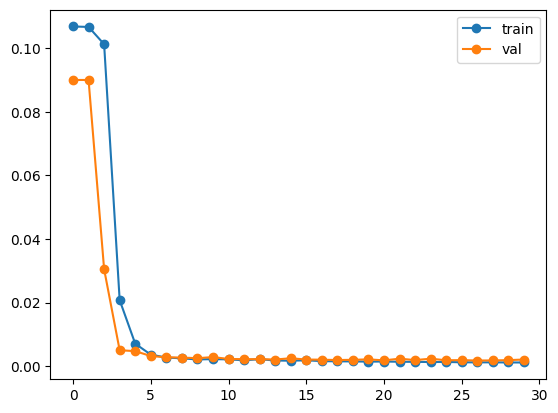

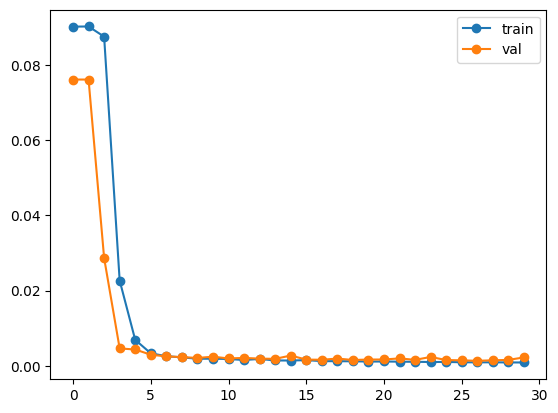

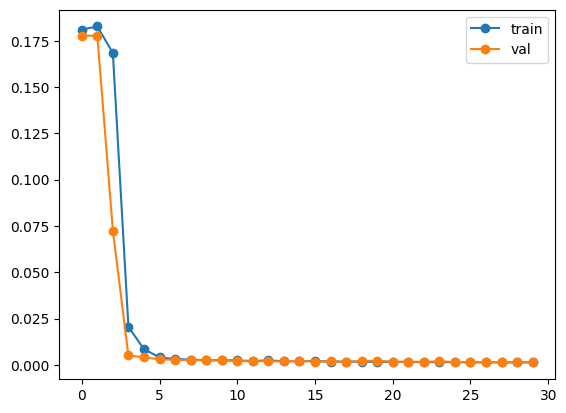

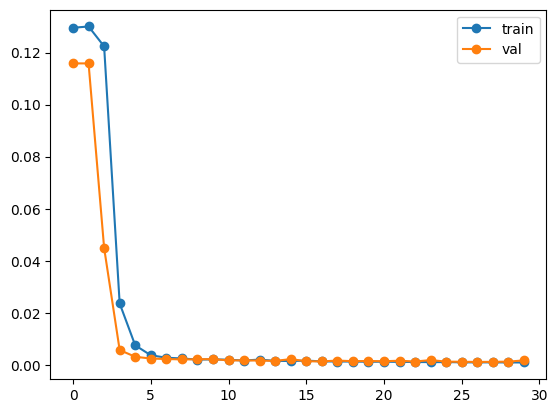


[Epoch    31 of 200] loss_1: 0.001044 val_loss_1: 0.002236 loss_2: 0.001090 val_loss_2: 0.001702 loss_3: 0.001008 val_loss_3: 0.001576 loss_4: 0.001023 val_loss_4: 0.001471 loss_5: 0.001227 val_loss_5: 0.002050 loss_6: 0.000893 val_loss_6: 0.001588 loss_7: 0.001322 val_loss_7: 0.001537 loss_8: 0.000928 val_loss_8: 0.001216
[model_1] EarlyStopping counter: 4 out of 5
[model_2] EarlyStopping counter: 4 out of 5
[model_3] EarlyStopping counter: 5 out of 5
[model_4] EarlyStopping counter: 4 out of 5
[model_5] EarlyStopping counter: 4 out of 5
[model_6] EarlyStopping counter: 4 out of 5
[model_7] EarlyStopping counter: 3 out of 5
[model_8] EarlyStopping counter: 4 out of 5
Early stopping - model_1
Early stopping - model_2
Early stopping - model_3
Early stopping - model_4
Early stopping - model_5
Early stopping - model_6
Early stopping - model_8

[Epoch    32 of 200] loss_1: 0.000990 val_loss_1: 0.001956 loss_2: 0.001052 val_loss_2: 0.001566 loss_3: 0.000957 val_loss_3: 0.001478 loss_4: 0.0

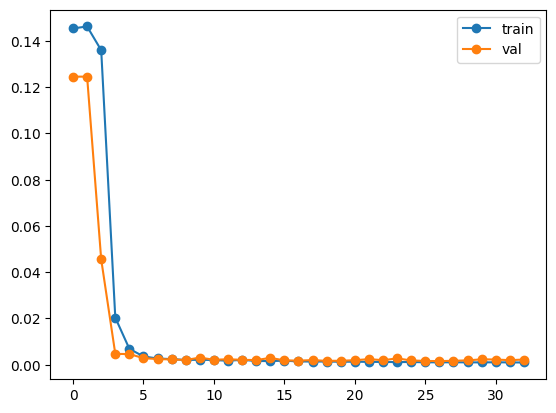

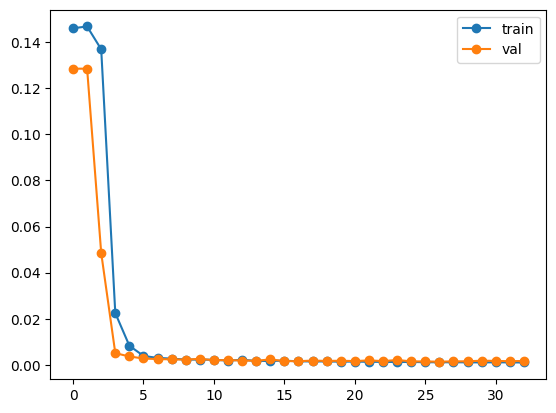

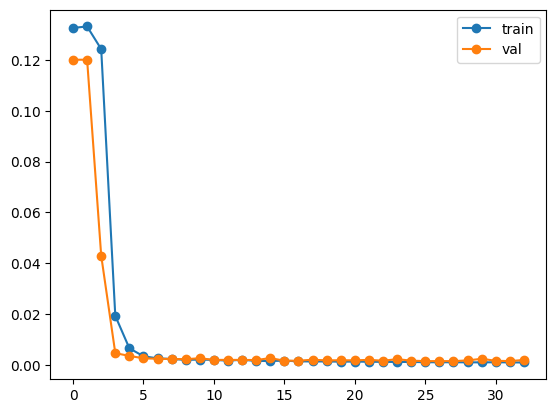

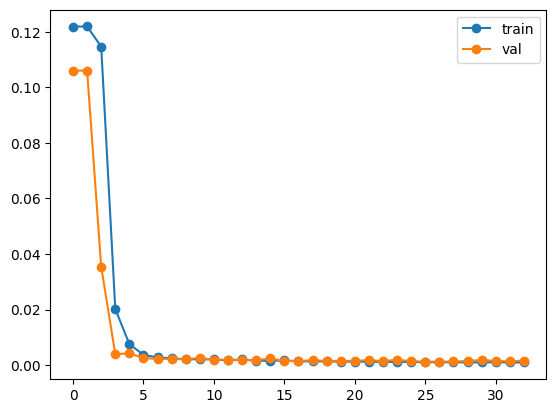

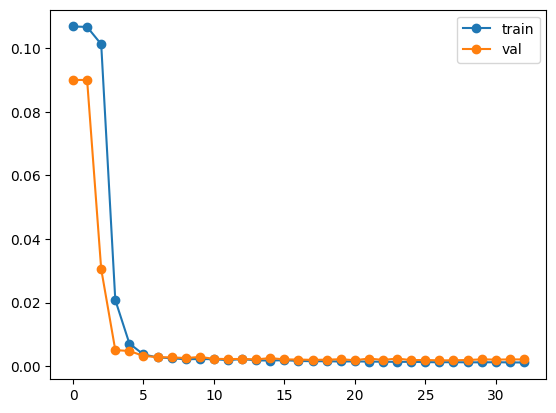

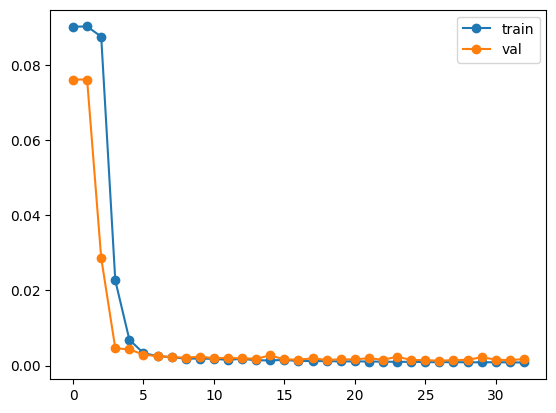

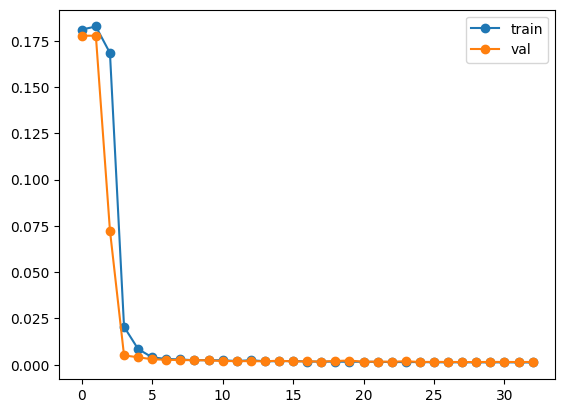

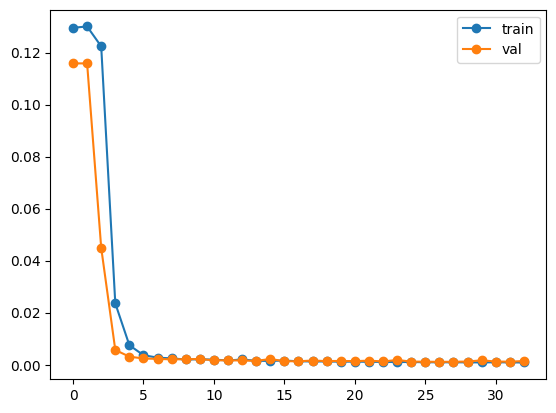


Total time of training: 1.1689857648478614 hours


In [50]:
start_time = time.time()

hist_loss_1 = np.zeros(config_args.epochs)
hist_loss_2 = np.zeros(config_args.epochs)
hist_loss_3 = np.zeros(config_args.epochs)
hist_loss_4 = np.zeros(config_args.epochs)
hist_loss_5 = np.zeros(config_args.epochs)
hist_loss_6 = np.zeros(config_args.epochs)
hist_loss_7 = np.zeros(config_args.epochs)
hist_loss_8 = np.zeros(config_args.epochs)

val_hist_loss_1 = np.zeros(config_args.epochs)
val_hist_loss_2 = np.zeros(config_args.epochs)
val_hist_loss_3 = np.zeros(config_args.epochs)
val_hist_loss_4 = np.zeros(config_args.epochs)
val_hist_loss_5 = np.zeros(config_args.epochs)
val_hist_loss_6 = np.zeros(config_args.epochs)
val_hist_loss_7 = np.zeros(config_args.epochs)
val_hist_loss_8 = np.zeros(config_args.epochs)

val_loss_best_1 = np.inf
val_loss_best_2 = np.inf
val_loss_best_3 = np.inf
val_loss_best_4 = np.inf
val_loss_best_5 = np.inf
val_loss_best_6 = np.inf
val_loss_best_7 = np.inf
val_loss_best_8 = np.inf

count_1 = 0
count_2 = 0
count_3 = 0
count_4 = 0
count_5 = 0
count_6 = 0
count_7 = 0
count_8 = 0

for epoch in range(config_args.epochs):

    # Switching all models in training mode
    model_1.train()
    model_2.train()
    model_3.train()
    model_4.train()
    model_5.train()
    model_6.train()
    model_7.train()
    model_8.train()

    running_loss_1 = 0
    running_loss_2 = 0
    running_loss_3 = 0
    running_loss_4 = 0
    running_loss_5 = 0
    running_loss_6 = 0
    running_loss_7 = 0
    running_loss_8 = 0

    for batch, (categorical_var, continuous_var, target_var) in enumerate(train_dataloader):

        # Setting the gradients to zero
        optimizer_1.zero_grad()
        optimizer_2.zero_grad()
        optimizer_3.zero_grad()
        optimizer_4.zero_grad()
        optimizer_5.zero_grad()
        optimizer_6.zero_grad()
        optimizer_7.zero_grad()
        optimizer_8.zero_grad()

        # The categorical variables are common for all zones.
        common_categorical = copy.deepcopy(categorical_var).to(device)

        zone_1_continuous = copy.deepcopy(continuous_var[:, :, 0:6]).to(device)
        zone_2_continuous = copy.deepcopy(continuous_var[:, :, 6:12]).to(device)
        zone_3_continuous = copy.deepcopy(continuous_var[:, :, 12:18]).to(device)
        zone_4_continuous = copy.deepcopy(continuous_var[:, :, 18:24]).to(device)
        zone_5_continuous = copy.deepcopy(continuous_var[:, :, 24:30]).to(device)
        zone_6_continuous = copy.deepcopy(continuous_var[:, :, 30:36]).to(device)
        zone_7_continuous = copy.deepcopy(continuous_var[:, :, 36:42]).to(device)
        zone_8_continuous = copy.deepcopy(continuous_var[:, :, 42:48]).to(device)

        zone_1_target = copy.deepcopy(target_var[:, :, 0:1])
        zone_2_target = copy.deepcopy(target_var[:, :, 1:2])
        zone_3_target = copy.deepcopy(target_var[:, :, 2:3])
        zone_4_target = copy.deepcopy(target_var[:, :, 3:4])
        zone_5_target = copy.deepcopy(target_var[:, :, 4:5])
        zone_6_target = copy.deepcopy(target_var[:, :, 5:6])
        zone_7_target = copy.deepcopy(target_var[:, :, 6:7])
        zone_8_target = copy.deepcopy(target_var[:, :, 7:8])

        # Propagating through the network
        out_vae_1, out_transformer_1 = model_1(common_categorical, zone_1_continuous)
        out_vae_2, out_transformer_2 = model_2(common_categorical, zone_2_continuous)
        out_vae_3, out_transformer_3 = model_3(common_categorical, zone_3_continuous)
        out_vae_4, out_transformer_4 = model_4(common_categorical, zone_4_continuous)
        out_vae_5, out_transformer_5 = model_5(common_categorical, zone_5_continuous)
        out_vae_6, out_transformer_6 = model_6(common_categorical, zone_6_continuous)
        out_vae_7, out_transformer_7 = model_7(common_categorical, zone_7_continuous)
        out_vae_8, out_transformer_8 = model_8(common_categorical, zone_8_continuous)

        # Calculating the pinball loss
        loss_1 = loss_function(out_transformer_1, zone_1_target.to(device))
        loss_2 = loss_function(out_transformer_2, zone_2_target.to(device))
        loss_3 = loss_function(out_transformer_3, zone_3_target.to(device))
        loss_4 = loss_function(out_transformer_4, zone_4_target.to(device))
        loss_5 = loss_function(out_transformer_5, zone_5_target.to(device))
        loss_6 = loss_function(out_transformer_6, zone_6_target.to(device))
        loss_7 = loss_function(out_transformer_7, zone_7_target.to(device))
        loss_8 = loss_function(out_transformer_8, zone_8_target.to(device))

        # Back-Propagating the loss
        loss_1.backward()
        loss_2.backward()
        loss_3.backward()
        loss_4.backward()
        loss_5.backward()
        loss_6.backward()
        loss_7.backward()
        loss_8.backward()

        # Updating the parameters
        optimizer_1.step()
        optimizer_2.step()
        optimizer_3.step()
        optimizer_4.step()
        optimizer_5.step()
        optimizer_6.step()
        optimizer_7.step()
        optimizer_8.step()

        # Accumulating the running loss
        running_loss_1 += loss_1.item()
        running_loss_2 += loss_2.item()
        running_loss_3 += loss_3.item()
        running_loss_4 += loss_4.item()
        running_loss_5 += loss_5.item()
        running_loss_6 += loss_6.item()
        running_loss_7 += loss_7.item()
        running_loss_8 += loss_8.item()

        train_loss_1 = running_loss_1/len(train_dataloader)
        train_loss_2 = running_loss_2/len(train_dataloader)
        train_loss_3 = running_loss_3/len(train_dataloader)
        train_loss_4 = running_loss_4/len(train_dataloader)
        train_loss_5 = running_loss_5/len(train_dataloader)
        train_loss_6 = running_loss_6/len(train_dataloader)
        train_loss_7 = running_loss_7/len(train_dataloader)
        train_loss_8 = running_loss_8/len(train_dataloader)


        val_loss_1 = compute_val_point_score(model_1, test_dataloader,
                                             loss_function, "zone_1",
                                             device).item()
        val_loss_2 = compute_val_point_score(model_2, test_dataloader,
                                             loss_function, "zone_2",
                                             device).item()
        val_loss_3 = compute_val_point_score(model_3, test_dataloader,
                                             loss_function, "zone_3",
                                             device).item()
        val_loss_4 = compute_val_point_score(model_4, test_dataloader,
                                             loss_function, "zone_4",
                                             device).item()
        val_loss_5 = compute_val_point_score(model_5, test_dataloader,
                                             loss_function, "zone_5",
                                             device).item()
        val_loss_6 = compute_val_point_score(model_6, test_dataloader,
                                             loss_function, "zone_6",
                                             device).item()
        val_loss_7 = compute_val_point_score(model_7, test_dataloader,
                                             loss_function, "zone_7",
                                             device).item()
        val_loss_8 = compute_val_point_score(model_8, test_dataloader,
                                             loss_function, "zone_8",
                                             device).item()

        hist_loss_1[epoch] = train_loss_1
        hist_loss_2[epoch] = train_loss_2
        hist_loss_3[epoch] = train_loss_3
        hist_loss_4[epoch] = train_loss_4
        hist_loss_5[epoch] = train_loss_5
        hist_loss_6[epoch] = train_loss_6
        hist_loss_7[epoch] = train_loss_7
        hist_loss_8[epoch] = train_loss_8

        val_hist_loss_1[epoch] = val_loss_1
        val_hist_loss_2[epoch] = val_loss_2
        val_hist_loss_3[epoch] = val_loss_3
        val_hist_loss_4[epoch] = val_loss_4
        val_hist_loss_5[epoch] = val_loss_5
        val_hist_loss_6[epoch] = val_loss_6
        val_hist_loss_7[epoch] = val_loss_7
        val_hist_loss_8[epoch] = val_loss_8
        
        
    print('\n[Epoch {t:5d} of {epochs}] loss_1: {loss_1:1.6f} val_loss_1: {val_loss_1:1.6f} loss_2: {loss_2:1.6f} val_loss_2: {val_loss_2:1.6f} loss_3: {loss_3:1.6f} val_loss_3: {val_loss_3:1.6f} loss_4: {loss_4:1.6f} val_loss_4: {val_loss_4:1.6f} loss_5: {loss_5:1.6f} val_loss_5: {val_loss_5:1.6f} loss_6: {loss_6:1.6f} val_loss_6: {val_loss_6:1.6f} loss_7: {loss_7:1.6f} val_loss_7: {val_loss_7:1.6f} loss_8: {loss_8:1.6f} val_loss_8: {val_loss_8:1.6f}'.format(t=epoch+1,
                                                                                                                                                                                                          epochs=config_args.epochs,
                                                                                                                                                                                                          loss_1=train_loss_1,
                                                                                                                                                                                                          val_loss_1=val_loss_1,
                                                                                                                                                                                                          loss_2=train_loss_2, 
                                                                                                                                                                                                          val_loss_2=val_loss_2,
                                                                                                                                                                                                          loss_3=train_loss_3,
                                                                                                                                                                                                          val_loss_3=val_loss_3,
                                                                                                                                                                                                          loss_4=train_loss_4,
                                                                                                                                                                                                          val_loss_4=val_loss_4,
                                                                                                                                                                                                          loss_5=train_loss_5,
                                                                                                                                                                                                          val_loss_5=val_loss_5,
                                                                                                                                                                                                          loss_6=train_loss_6,
                                                                                                                                                                                                          val_loss_6=val_loss_6,
                                                                                                                                                                                                          loss_7=train_loss_7,
                                                                                                                                                                                                          val_loss_7=val_loss_7,
                                                                                                                                                                                                          loss_8=train_loss_8,
                                                                                                                                                                                                          val_loss_8=val_loss_8))
    
    # Employing early stopping to avoid overfitting
    early_stopping_1(val_loss_1, model_1)
    early_stopping_2(val_loss_2, model_2)
    early_stopping_3(val_loss_3, model_3)
    early_stopping_4(val_loss_4, model_4)
    early_stopping_5(val_loss_5, model_5)
    early_stopping_6(val_loss_6, model_6)
    early_stopping_7(val_loss_7, model_7)
    early_stopping_8(val_loss_8, model_8)

    if early_stopping_1.early_stop and count_1 < 1:
        print("Early stopping - {}".format(early_stopping_1.model_name))

    if early_stopping_2.early_stop and count_2 < 1:
        print("Early stopping - {}".format(early_stopping_2.model_name))

    if early_stopping_3.early_stop and count_3 < 1:
        print("Early stopping - {}".format(early_stopping_3.model_name))
        
    if early_stopping_4.early_stop and count_4 < 1:
        print("Early stopping - {}".format(early_stopping_4.model_name))

    if early_stopping_5.early_stop and count_5 < 1:
        print("Early stopping - {}".format(early_stopping_5.model_name))

    if early_stopping_6.early_stop and count_6 < 1:
        print("Early stopping - {}".format(early_stopping_6.model_name))
    
    if early_stopping_7.early_stop and count_7 < 1:
        print("Early stopping - {}".format(early_stopping_7.model_name))

    if early_stopping_8.early_stop and count_8 < 1:
        print("Early stopping - {}".format(early_stopping_8.model_name))


    if all((early_stopping_1.early_stop, early_stopping_2.early_stop, early_stopping_3.early_stop, 
            early_stopping_4.early_stop, early_stopping_5.early_stop, early_stopping_6.early_stop,
            early_stopping_7.early_stop, early_stopping_8.early_stop)):
        print("\nAll model stopped early...")
        break
        
            
    if (epoch + 1) % config_args.update_freq == 0:
        print("The plots at epoch {} are:\n".format(epoch+1))
        plt.plot(np.trim_zeros(hist_loss_1, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_1, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        plt.plot(np.trim_zeros(hist_loss_2, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_2, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        plt.plot(np.trim_zeros(hist_loss_3, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_3, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        plt.plot(np.trim_zeros(hist_loss_4, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_4, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        plt.plot(np.trim_zeros(hist_loss_5, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_5, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        plt.plot(np.trim_zeros(hist_loss_6, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_6, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        plt.plot(np.trim_zeros(hist_loss_7, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_7, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

        plt.plot(np.trim_zeros(hist_loss_8, 'b'), 'o-', label='train')
        plt.plot(np.trim_zeros(val_hist_loss_8, 'b'), 'o-', label='val')
        plt.legend()
        plt.show()

plt.plot(np.trim_zeros(hist_loss_1, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_1, 'b'), 'o-', label='val')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_2, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_2, 'b'), 'o-', label='val')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_3, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_3, 'b'), 'o-', label='val')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_4, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_4, 'b'), 'o-', label='val')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_5, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_5, 'b'), 'o-', label='val')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_6, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_6, 'b'), 'o-', label='val')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_7, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_7, 'b'), 'o-', label='val')
plt.legend()
plt.show()

plt.plot(np.trim_zeros(hist_loss_8, 'b'), 'o-', label='train')
plt.plot(np.trim_zeros(val_hist_loss_8, 'b'), 'o-', label='val')
plt.legend()
plt.show()

end_time = time.time()

total_time = end_time - start_time
print("\nTotal time of training: {} hours".format(total_time/3600))

### LOADING AND GENERATING RESULTS ON TEST DATALOADER

In [51]:
# Loading the models
best_vae_transformer_1 = load_from_checkpoint(model_1, model_path_1)
best_vae_transformer_2 = load_from_checkpoint(model_2, model_path_2)
best_vae_transformer_3 = load_from_checkpoint(model_3, model_path_3)
best_vae_transformer_4 = load_from_checkpoint(model_4, model_path_4)
best_vae_transformer_5 = load_from_checkpoint(model_5, model_path_5)
best_vae_transformer_6 = load_from_checkpoint(model_6, model_path_6)
best_vae_transformer_7 = load_from_checkpoint(model_7, model_path_7)
best_vae_transformer_8 = load_from_checkpoint(model_8, model_path_8)


In [52]:
point_pred_1 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
point_pred_2 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
point_pred_3 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
point_pred_4 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
point_pred_5 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
point_pred_6 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
point_pred_7 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
point_pred_8 = np.empty(shape=(len(test_dataloader.dataset), 24, model_args.d_output))
idx_pred_1 = 0
idx_pred_2 = 0
idx_pred_3 = 0
idx_pred_4 = 0
idx_pred_5 = 0
idx_pred_6 = 0
idx_pred_7 = 0
idx_pred_8 = 0

# Switching all models to eval mode
model_1.eval()
model_2.eval()
model_3.eval()
model_4.eval()
model_5.eval()
model_6.eval()
model_7.eval()
model_8.eval()

with torch.no_grad():
    for (categorical_var, continuous_var, target_var) in tqdm(test_dataloader, total=len(test_dataloader)):

        # The categorical variables are common for all zones.
        common_categorical = copy.deepcopy(categorical_var).to(device)

        zone_1_continuous = copy.deepcopy(continuous_var[:, :, 0:6]).to(device)
        zone_2_continuous = copy.deepcopy(continuous_var[:, :, 6:12]).to(device)
        zone_3_continuous = copy.deepcopy(continuous_var[:, :, 12:18]).to(device)
        zone_4_continuous = copy.deepcopy(continuous_var[:, :, 18:24]).to(device)
        zone_5_continuous = copy.deepcopy(continuous_var[:, :, 24:30]).to(device)
        zone_6_continuous = copy.deepcopy(continuous_var[:, :, 30:36]).to(device)
        zone_7_continuous = copy.deepcopy(continuous_var[:, :, 36:42]).to(device)
        zone_8_continuous = copy.deepcopy(continuous_var[:, :, 42:48]).to(device)

        zone_1_target = copy.deepcopy(target_var[:, :, 0:1])
        zone_2_target = copy.deepcopy(target_var[:, :, 1:2])
        zone_3_target = copy.deepcopy(target_var[:, :, 2:3])
        zone_4_target = copy.deepcopy(target_var[:, :, 3:4])
        zone_5_target = copy.deepcopy(target_var[:, :, 4:5])
        zone_6_target = copy.deepcopy(target_var[:, :, 5:6])
        zone_7_target = copy.deepcopy(target_var[:, :, 6:7])
        zone_8_target = copy.deepcopy(target_var[:, :, 7:8])

        # Propagating through the network
        out_vae_1, out_transformer_1 = model_1(common_categorical, zone_1_continuous)
        out_vae_2, out_transformer_2 = model_2(common_categorical, zone_2_continuous)
        out_vae_3, out_transformer_3 = model_3(common_categorical, zone_3_continuous)
        out_vae_4, out_transformer_4 = model_4(common_categorical, zone_4_continuous)
        out_vae_5, out_transformer_5 = model_5(common_categorical, zone_5_continuous)
        out_vae_6, out_transformer_6 = model_6(common_categorical, zone_6_continuous)
        out_vae_7, out_transformer_7 = model_7(common_categorical, zone_7_continuous)
        out_vae_8, out_transformer_8 = model_8(common_categorical, zone_8_continuous)

        # Concatenating the predictions
        point_pred_1[idx_pred_1:idx_pred_1+zone_1_continuous.shape[0]] = out_transformer_1.cpu().numpy()

        point_pred_2[idx_pred_2:idx_pred_2+zone_2_continuous.shape[0]] = out_transformer_2.cpu().numpy()

        point_pred_3[idx_pred_3:idx_pred_3+zone_3_continuous.shape[0]] = out_transformer_3.cpu().numpy()

        point_pred_4[idx_pred_4:idx_pred_4+zone_4_continuous.shape[0]] = out_transformer_4.cpu().numpy()

        point_pred_5[idx_pred_5:idx_pred_5+zone_5_continuous.shape[0]] = out_transformer_5.cpu().numpy()

        point_pred_6[idx_pred_6:idx_pred_6+zone_6_continuous.shape[0]] = out_transformer_6.cpu().numpy()

        point_pred_7[idx_pred_7:idx_pred_7+zone_7_continuous.shape[0]] = out_transformer_7.cpu().numpy()

        point_pred_8[idx_pred_8:idx_pred_8+zone_8_continuous.shape[0]] = out_transformer_8.cpu().numpy()

        idx_pred_1 += zone_1_continuous.shape[0]
        idx_pred_2 += zone_2_continuous.shape[0]
        idx_pred_3 += zone_3_continuous.shape[0]
        idx_pred_4 += zone_4_continuous.shape[0]
        idx_pred_5 += zone_5_continuous.shape[0]
        idx_pred_6 += zone_6_continuous.shape[0]
        idx_pred_7 += zone_7_continuous.shape[0]
        idx_pred_8 += zone_8_continuous.shape[0]

100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


#### FORMATTING PREDICTED AND TRUE DATA FOR GENERATING RESULTS

In [53]:
# Reshaping the predicted quantiles
point_pred_arr_1 = point_pred_1.reshape(-1, model_args.d_output)
point_pred_arr_2 = point_pred_2.reshape(-1, model_args.d_output)
point_pred_arr_3 = point_pred_3.reshape(-1, model_args.d_output)
point_pred_arr_4 = point_pred_4.reshape(-1, model_args.d_output)
point_pred_arr_5 = point_pred_5.reshape(-1, model_args.d_output)
point_pred_arr_6 = point_pred_6.reshape(-1, model_args.d_output)
point_pred_arr_7 = point_pred_7.reshape(-1, model_args.d_output)
point_pred_arr_8 = point_pred_8.reshape(-1, model_args.d_output)

point_pred_arr_1.shape

(8760, 1)

In [54]:
point_pred_1_inv = point_pred_arr_1 * (mm_scaler_Y.data_max_[0] - mm_scaler_Y.data_min_[0]) + mm_scaler_Y.data_min_[0]
point_pred_2_inv = point_pred_arr_2 * (mm_scaler_Y.data_max_[1] - mm_scaler_Y.data_min_[1]) + mm_scaler_Y.data_min_[1]
point_pred_3_inv = point_pred_arr_3 * (mm_scaler_Y.data_max_[2] - mm_scaler_Y.data_min_[2]) + mm_scaler_Y.data_min_[2]
point_pred_4_inv = point_pred_arr_4 * (mm_scaler_Y.data_max_[3] - mm_scaler_Y.data_min_[3]) + mm_scaler_Y.data_min_[3]
point_pred_5_inv = point_pred_arr_5 * (mm_scaler_Y.data_max_[4] - mm_scaler_Y.data_min_[4]) + mm_scaler_Y.data_min_[4]
point_pred_6_inv = point_pred_arr_6 * (mm_scaler_Y.data_max_[5] - mm_scaler_Y.data_min_[5]) + mm_scaler_Y.data_min_[5]
point_pred_7_inv = point_pred_arr_7 * (mm_scaler_Y.data_max_[6] - mm_scaler_Y.data_min_[6]) + mm_scaler_Y.data_min_[6]
point_pred_8_inv = point_pred_arr_8 * (mm_scaler_Y.data_max_[7] - mm_scaler_Y.data_min_[7]) + mm_scaler_Y.data_min_[7]

point_pred_1_inv.shape

(8760, 1)

In [55]:
# Reshaping the true data
Y_test_1 = target_samples_testing[:, :, 0:1]
Y_test_2 = target_samples_testing[:, :, 1:2]
Y_test_3 = target_samples_testing[:, :, 2:3]
Y_test_4 = target_samples_testing[:, :, 3:4]
Y_test_5 = target_samples_testing[:, :, 4:5]
Y_test_6 = target_samples_testing[:, :, 5:6]
Y_test_7 = target_samples_testing[:, :, 6:7]
Y_test_8 = target_samples_testing[:, :, 7:8]

yArr_1 = Y_test_1.reshape(Y_test_1.shape[0] * Y_test_1.shape[1], Y_test_1.shape[2]).numpy()
yArr_2 = Y_test_2.reshape(Y_test_2.shape[0] * Y_test_2.shape[1], Y_test_2.shape[2]).numpy()
yArr_3 = Y_test_3.reshape(Y_test_3.shape[0] * Y_test_3.shape[1], Y_test_3.shape[2]).numpy()
yArr_4 = Y_test_4.reshape(Y_test_4.shape[0] * Y_test_4.shape[1], Y_test_4.shape[2]).numpy()
yArr_5 = Y_test_5.reshape(Y_test_5.shape[0] * Y_test_5.shape[1], Y_test_5.shape[2]).numpy()
yArr_6 = Y_test_6.reshape(Y_test_6.shape[0] * Y_test_6.shape[1], Y_test_6.shape[2]).numpy()
yArr_7 = Y_test_7.reshape(Y_test_7.shape[0] * Y_test_7.shape[1], Y_test_7.shape[2]).numpy()
yArr_8 = Y_test_8.reshape(Y_test_8.shape[0] * Y_test_8.shape[1], Y_test_8.shape[2]).numpy()

yArr_1.shape

(8760, 1)

In [56]:
yArr_1_inv = yArr_1 * (mm_scaler_Y.data_max_[0] - mm_scaler_Y.data_min_[0]) + mm_scaler_Y.data_min_[0]
yArr_2_inv = yArr_2 * (mm_scaler_Y.data_max_[1] - mm_scaler_Y.data_min_[1]) + mm_scaler_Y.data_min_[1]
yArr_3_inv = yArr_3 * (mm_scaler_Y.data_max_[2] - mm_scaler_Y.data_min_[2]) + mm_scaler_Y.data_min_[2]
yArr_4_inv = yArr_4 * (mm_scaler_Y.data_max_[3] - mm_scaler_Y.data_min_[3]) + mm_scaler_Y.data_min_[3]
yArr_5_inv = yArr_5 * (mm_scaler_Y.data_max_[4] - mm_scaler_Y.data_min_[4]) + mm_scaler_Y.data_min_[4]
yArr_6_inv = yArr_6 * (mm_scaler_Y.data_max_[5] - mm_scaler_Y.data_min_[5]) + mm_scaler_Y.data_min_[5]
yArr_7_inv = yArr_7 * (mm_scaler_Y.data_max_[6] - mm_scaler_Y.data_min_[6]) + mm_scaler_Y.data_min_[6]
yArr_8_inv = yArr_8 * (mm_scaler_Y.data_max_[7] - mm_scaler_Y.data_min_[7]) + mm_scaler_Y.data_min_[7]

#### CALCULATING THE MAPE ON TEST DATA

In [57]:
compare_df_1 = pd.DataFrame(data= {"Values": yArr_1_inv[:, 0], "Predictions": point_pred_1_inv[:, 0]})
compare_df_1

,Values,Predictions
0,1131.099976,1102.483484
1,1082.000000,1077.260095
2,1042.000000,1072.611525
3,1023.400024,1076.499907
4,1021.400024,1088.163095
...,...,...
8755,1452.600098,1519.396861
8756,1399.699951,1470.951334
8757,1339.000000,1410.701868
8758,1280.900024,1325.360895


In [58]:
compare_df_2 = pd.DataFrame(data= {"Values": yArr_2_inv[:, 0], "Predictions": point_pred_2_inv[:, 0]})
compare_df_2

,Values,Predictions
0,1597.599976,1600.747069
1,1539.599976,1542.329589
2,1490.599976,1484.423618
3,1455.799927,1484.399941
4,1426.699951,1502.663050
...,...,...
8755,1947.500000,2016.190851
8756,1881.500000,1975.894984
8757,1804.599976,1898.816154
8758,1734.199951,1798.497091


In [59]:
compare_df_3 = pd.DataFrame(data= {"Values": yArr_3_inv[:, 0], "Predictions": point_pred_3_inv[:, 0]})
compare_df_3

,Values,Predictions
0,581.799988,554.705093
1,560.400024,526.111492
2,536.300049,509.327557
3,516.299988,499.302376
4,501.700012,507.231137
...,...,...
8755,696.400024,742.873193
8756,668.500000,722.038936
8757,637.900024,689.850871
8758,608.400024,645.549225


In [60]:
compare_df_4 = pd.DataFrame(data= {"Values": yArr_4_inv[:, 0], "Predictions": point_pred_4_inv[:, 0]})
compare_df_4

,Values,Predictions
0,897.500000,933.108636
1,861.000000,888.322227
2,834.900024,861.827597
3,807.500000,855.764385
4,803.000000,851.424903
...,...,...
8755,1179.400024,1221.134355
8756,1136.699951,1188.060755
8757,1094.500000,1142.278180
8758,1049.599976,1080.947402


In [61]:
compare_df_5 = pd.DataFrame(data= {"Values": yArr_5_inv[:, 0], "Predictions": point_pred_5_inv[:, 0]})
compare_df_5

,Values,Predictions
0,948.599976,958.041737
1,896.399963,925.340948
2,848.299988,894.450549
3,834.500000,879.553350
4,826.799988,888.970587
...,...,...
8755,1180.199951,1284.093384
8756,1134.000000,1249.624331
8757,1091.199951,1191.952656
8758,1041.299927,1119.354708


In [62]:
compare_df_6 = pd.DataFrame(data= {"Values": yArr_6_inv[:, 0], "Predictions": point_pred_6_inv[:, 0]})
compare_df_6

,Values,Predictions
0,1974.199951,1904.248640
1,1848.900024,1805.835862
2,1748.800049,1761.385869
3,1675.900024,1740.283027
4,1649.200073,1756.328767
...,...,...
8755,2574.199951,2704.312599
8756,2446.300049,2612.398578
8757,2324.100098,2489.681627
8758,2201.800049,2332.951126


In [63]:
compare_df_7 = pd.DataFrame(data= {"Values": yArr_7_inv[:, 0], "Predictions": point_pred_7_inv[:, 0]})
compare_df_7

,Values,Predictions
0,272.500000,255.423552
1,260.000000,238.623314
2,252.500015,244.985135
3,237.900009,244.860609
4,234.100006,240.463044
...,...,...
8755,385.700012,407.893689
8756,366.200012,396.530416
8757,347.299988,375.500791
8758,326.500000,345.842797


In [64]:
compare_df_8 = pd.DataFrame(data= {"Values": yArr_8_inv[:, 0], "Predictions": point_pred_8_inv[:, 0]})
compare_df_8

,Values,Predictions
0,4896.000000,4652.879722
1,4719.600098,4497.046460
2,4532.899902,4403.785843
3,4395.600098,4268.235558
4,4322.600098,4339.772287
...,...,...
8755,5909.299805,6224.790769
8756,5689.200195,6037.425860
8757,5488.299805,5827.765155
8758,5276.000000,5492.692284


In [65]:
print("Saving the best trained models.")

# Saving the models
torch.save(best_vae_transformer_1, f"vae_transformer_models/L4_vae_transformer_1.pth")
torch.save(best_vae_transformer_2, f"vae_transformer_models/L4_vae_transformer_2.pth")
torch.save(best_vae_transformer_3, f"vae_transformer_models/L4_vae_transformer_3.pth")
torch.save(best_vae_transformer_4, f"vae_transformer_models/L4_vae_transformer_4.pth")
torch.save(best_vae_transformer_5, f"vae_transformer_models/L4_vae_transformer_5.pth")
torch.save(best_vae_transformer_6, f"vae_transformer_models/L4_vae_transformer_6.pth")
torch.save(best_vae_transformer_7, f"vae_transformer_models/L4_vae_transformer_7.pth")
torch.save(best_vae_transformer_8, f"vae_transformer_models/L4_vae_transformer_8.pth")

print("Saved !")

Saving the best trained models.
Saved !


#### EXAMINING THE RESULTS

In [66]:
mape_max_val = mm_scaler_Y.data_max_.max()

New MAPE:  0.4154826583438742
Old MAPE:  1.99863896780376


<Axes: >

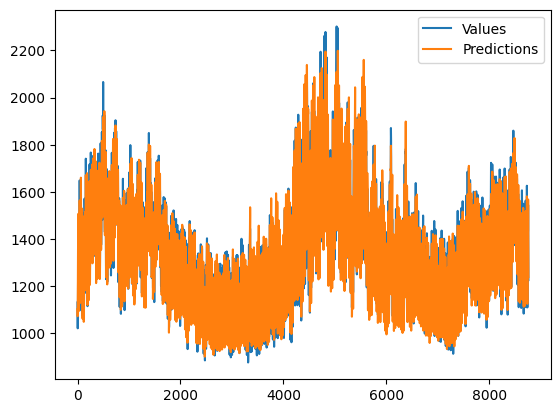

In [67]:
result_mape_1 = new_mape(compare_df_1["Values"], compare_df_1["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_1)
print("Old MAPE: ", mape(compare_df_1["Values"], compare_df_1["Predictions"]))
compare_df_1.plot()

New MAPE:  0.4506474496624744
Old MAPE:  1.8396327629732316


<Axes: >

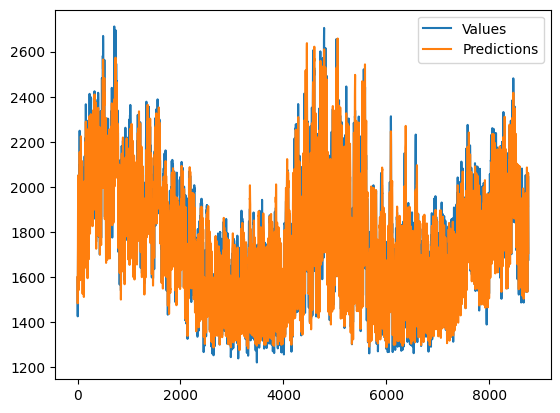

In [68]:
result_mape_2 = new_mape(compare_df_2["Values"], compare_df_2["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_2)
print("Old MAPE: ", mape(compare_df_2["Values"], compare_df_2["Predictions"]))
compare_df_2.plot()

New MAPE:  0.24351933483943466
Old MAPE:  1.936556020741444


<Axes: >

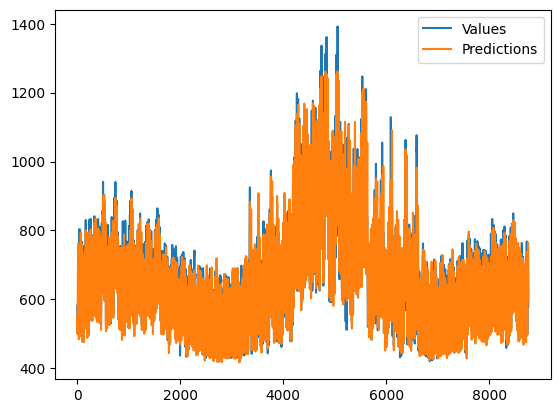

In [69]:
result_mape_3 = new_mape(compare_df_3["Values"], compare_df_3["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_3)
print("Old MAPE: ", mape(compare_df_3["Values"], compare_df_3["Predictions"]))
compare_df_3.plot()

New MAPE:  0.3140582020282262
Old MAPE:  1.8050519620933834


<Axes: >

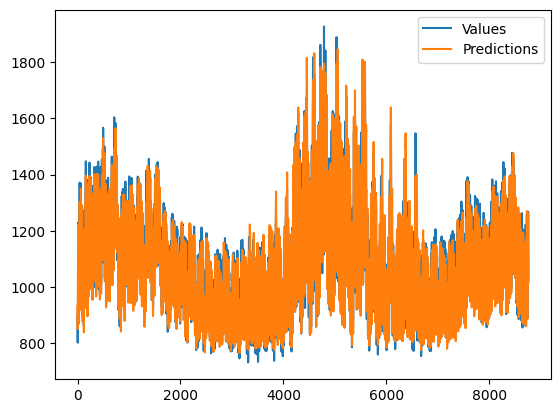

In [70]:
result_mape_4 = new_mape(compare_df_4["Values"], compare_df_4["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_4)
print("Old MAPE: ", mape(compare_df_4["Values"], compare_df_4["Predictions"]))
compare_df_4.plot()

New MAPE:  0.4142538917514794
Old MAPE:  2.0440699407763026


<Axes: >

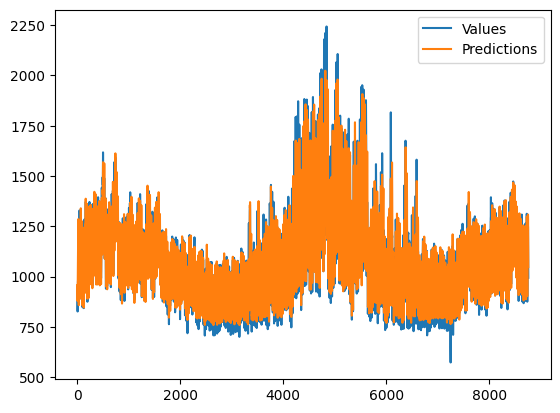

In [71]:
result_mape_5 = new_mape(compare_df_5["Values"], compare_df_5["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_5)
print("Old MAPE: ", mape(compare_df_5["Values"], compare_df_5["Predictions"]))
compare_df_5.plot()

New MAPE:  0.89282951723802
Old MAPE:  1.817595028959503


<Axes: >

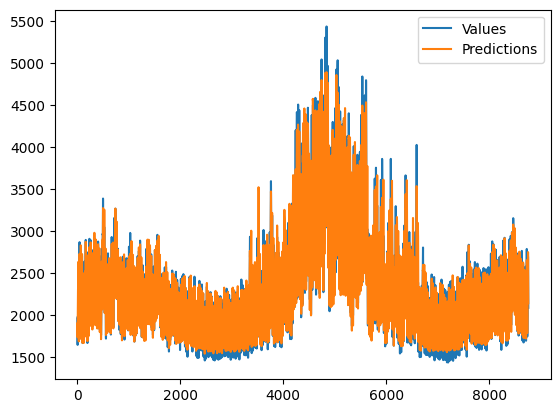

In [72]:
result_mape_6 = new_mape(compare_df_6["Values"], compare_df_6["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_6)
print("Old MAPE: ", mape(compare_df_6["Values"], compare_df_6["Predictions"]))
compare_df_6.plot()

New MAPE:  0.1443974346531326
Old MAPE:  2.4255484528429605


<Axes: >

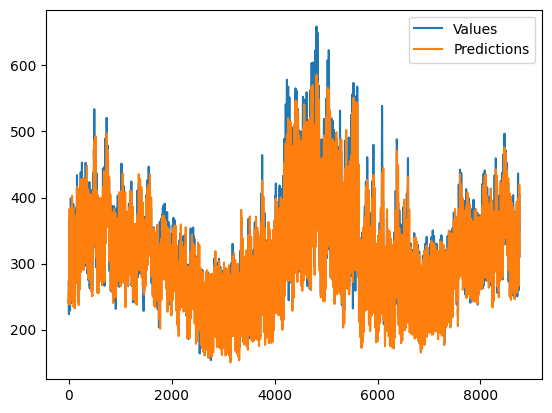

In [73]:
result_mape_7 = new_mape(compare_df_7["Values"], compare_df_7["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_7)
print("Old MAPE: ", mape(compare_df_7["Values"], compare_df_7["Predictions"]))
compare_df_7.plot()

New MAPE:  1.4939549606717564
Old MAPE:  1.5309361924871776


<Axes: >

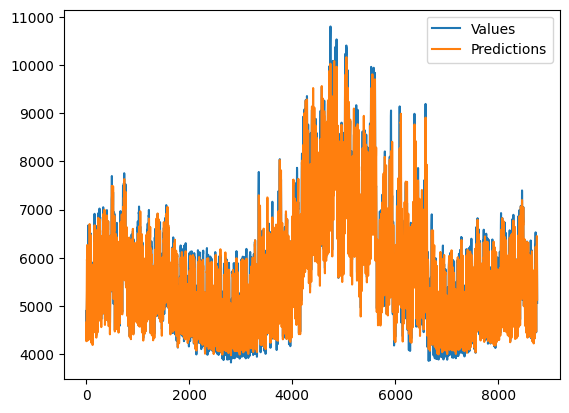

In [74]:
result_mape_8 = new_mape(compare_df_8["Values"], compare_df_8["Predictions"], max_val=mape_max_val)
print("New MAPE: ", result_mape_8)
print("Old MAPE: ", mape(compare_df_8["Values"], compare_df_8["Predictions"]))
compare_df_8.plot()

In [75]:
resultsDf = pd.DataFrame()
resultsDf["zone"] = [i.removesuffix('.csv') for i in fileList]
resultsDf["mape"] = [
result_mape_1, result_mape_2, result_mape_3,
result_mape_4, result_mape_5, result_mape_6,
result_mape_7, result_mape_8,
]

resultsDf.to_csv(os.path.join("lag_24_results", "v2_new_" + dataset + ".csv"), index=False)
print("Results saved !")

Results saved !


In [76]:
resultsDf

,zone,mape
0,CAPITL,0.415483
1,CENTRL,0.450647
2,DUNWOD,0.243519
3,GENESE,0.314058
4,HUD VL,0.414254
5,LONGIL,0.892830
6,MILLWD,0.144397
7,N.Y.C.,1.493955


In [77]:
# import IPython
# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

In [78]:
oldResultsDf = pd.DataFrame()
oldResultsDf["zone"] = [i.removesuffix('.csv') for i in fileList]
oldResultsDf["mape"] = [
    mape(compare_df_1["Values"], compare_df_1["Predictions"]), 
    mape(compare_df_2["Values"], compare_df_2["Predictions"]), 
    mape(compare_df_3["Values"], compare_df_3["Predictions"]),
    mape(compare_df_4["Values"], compare_df_4["Predictions"]),
    mape(compare_df_5["Values"], compare_df_5["Predictions"]),
    mape(compare_df_6["Values"], compare_df_6["Predictions"]),
    mape(compare_df_7["Values"], compare_df_7["Predictions"]),
    mape(compare_df_8["Values"], compare_df_8["Predictions"]),
]

oldResultsDf.to_csv(os.path.join("lag_24_results", "v2_old_" + dataset + ".csv"), index=False)
print("Results saved !")

oldResultsDf

Results saved !


,zone,mape
0,CAPITL,1.998639
1,CENTRL,1.839633
2,DUNWOD,1.936556
3,GENESE,1.805052
4,HUD VL,2.044070
5,LONGIL,1.817595
6,MILLWD,2.425548
7,N.Y.C.,1.530936
